---
title: Statistical analysis
description: Exploratory Data Analysis of Head Coaches and Match Results datasets
---

### Imports

In [752]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [753]:
sns.set_theme(context = 'paper', style = 'ticks', palette = 'deep', color_codes = True)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300

### Loading data

In [754]:
head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['Appointed', 'EndDate'])
head_coach = head_coach[head_coach['Tenure'] <= 3000]

### General plotting function

In [755]:
def create_regression_plot(data, x_value, y_value, y_leg, color, title, xlabel):
    plt.figure()
    sns.regplot(x=x_value, y=y_value, data=data, color=color, scatter_kws={'alpha':0.5}, label=y_leg + ' ratio')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f'{y_leg.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
    r, p = pearsonr(data[x_value], data[y_value])
    plt.legend([f'Pearson correlation : r = {r:.2f}, p = {p:.2f}'], loc='upper right')

In [756]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm


def prepare_data(data, x_value, y_value, degree=2):
    x = data[x_value].values.reshape(-1, 1)
    y = data[y_value]
    polynomial_features = PolynomialFeatures(degree=degree)
    xp = polynomial_features.fit_transform(x)
    return xp, y, polynomial_features

def fit_model(xp, y):
    model = sm.OLS(y, xp)
    results = model.fit()
    return results

def create_predictions(results, polynomial_features, x_min, x_max):
    xs = np.linspace(x_min, x_max).reshape(-1, 1)
    xs = polynomial_features.transform(xs)
    ys = results.predict(xs)
    predictions = results.get_prediction(xs)
    ci = predictions.conf_int()
    return xs, ys, ci

def create_polynomial_regression_plot(data, x_value, y_value, y_leg, color, title, xlabel, degree=2):
    xp, y, polynomial_features = prepare_data(data, x_value, y_value, degree)
    results = fit_model(xp, y)
    xs, ys, ci = create_predictions(results, polynomial_features, data[x_value].min(), data[x_value].max())

    plt.figure()
    plt.scatter(data[x_value], y, color=color, alpha=0.2)
    line, = plt.plot(xs[:,1], ys, color=color)
    plt.fill_between(xs[:,1], ci[:,0], ci[:,1], color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f'{y_leg.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

    r, p = pearsonr(data[x_value], data[y_value])
    plt.legend([line, line], 
               [f'Polynomial regression (degree {degree})', 
                f'Pearson correlation : $r = {r:.2f}$, $p = {p:.2f}$'], loc='upper right')

#### Relation between Head Coaches appointments results and Head Coaches Tenure in Club

In [757]:
head_coach['WinPercentage'] = head_coach['Wins'] / head_coach['Matches'] * 100
head_coach['DrawPercentage'] = head_coach['Draws'] / head_coach['Matches'] * 100
head_coach['LossPercentage'] = head_coach['Losses'] / head_coach['Matches'] * 100

title = ' Head Coaches Appointments {} Percentage over Head Coaches Tenure in Club'
x_label = 'Head Coach tenure (days)'

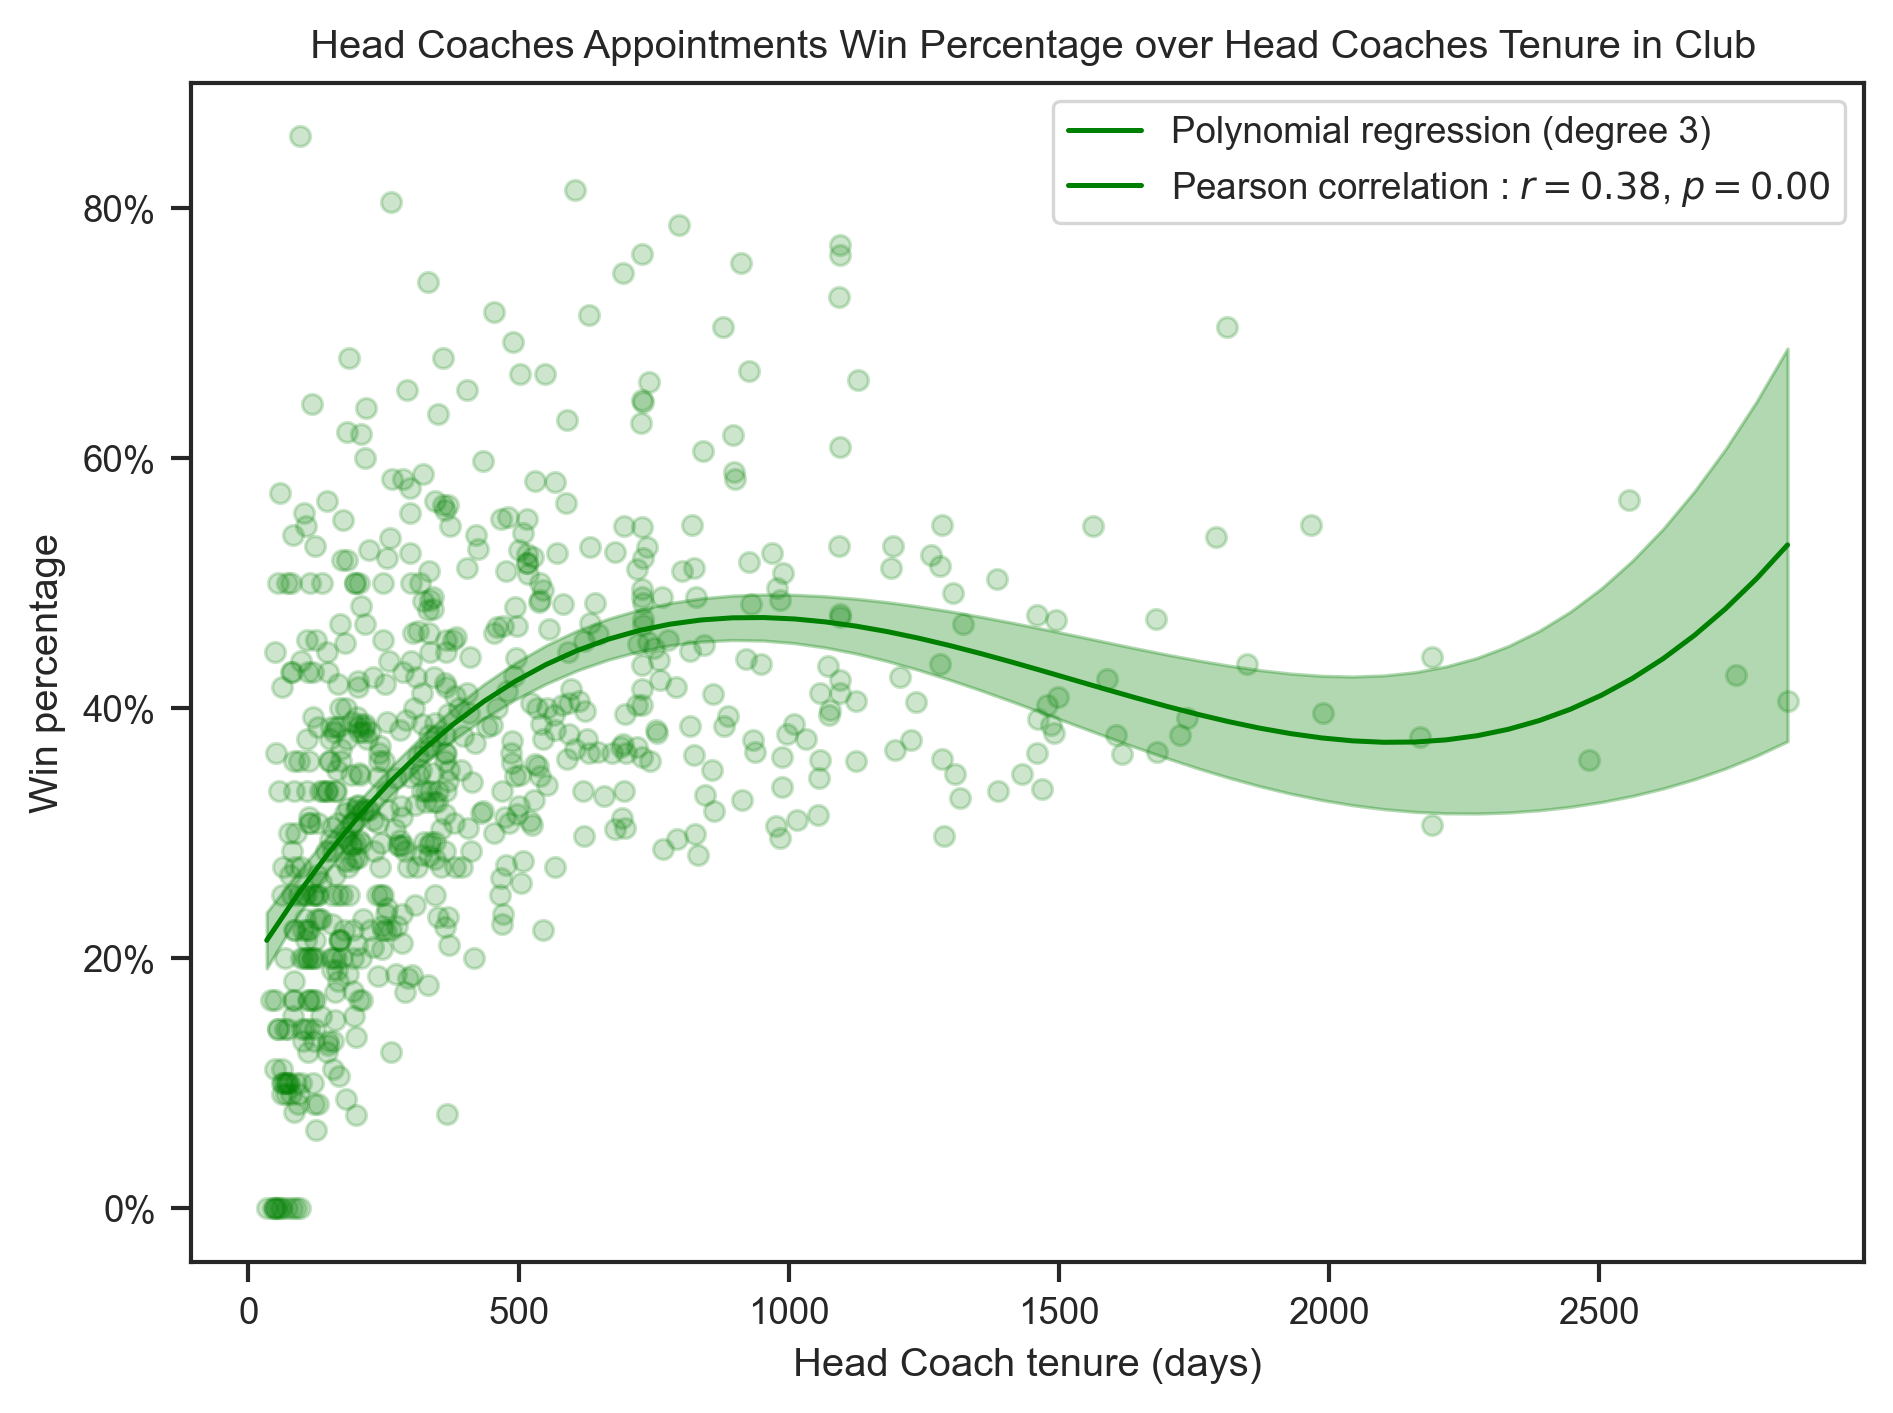

In [758]:
#| label: hc_win_ratio_over_days
create_polynomial_regression_plot(head_coach, 'Tenure', 'WinPercentage', 'Win', 'green', title.format('Win'), x_label, degree=3)

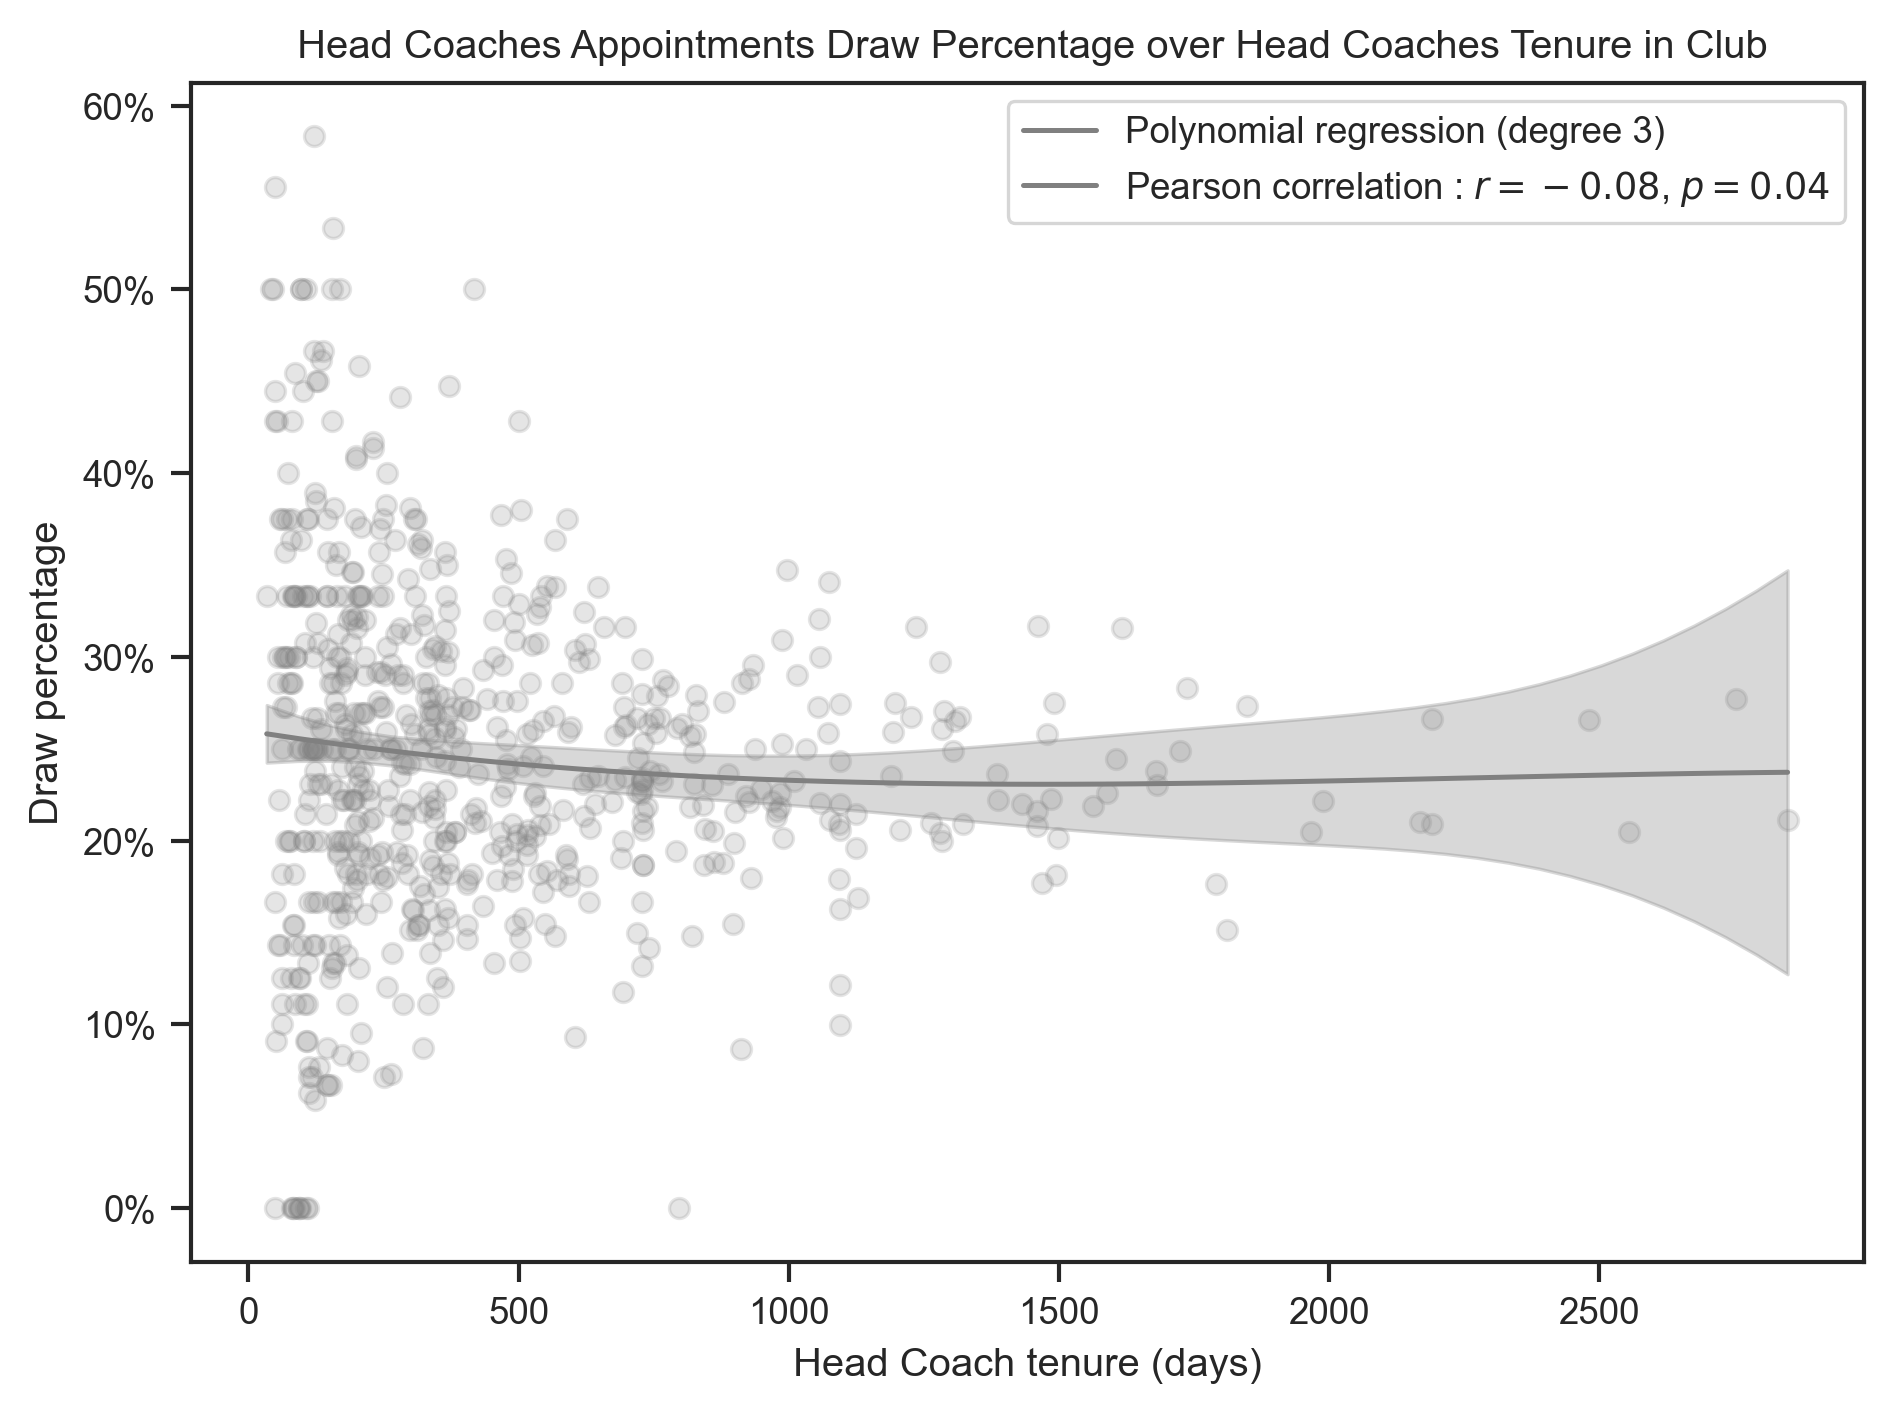

In [759]:
#| label: hc_draw_ratio_over_days
create_polynomial_regression_plot(head_coach, 'Tenure', 'DrawPercentage', 'Draw', 'gray', title.format('Draw'), x_label, degree=3)

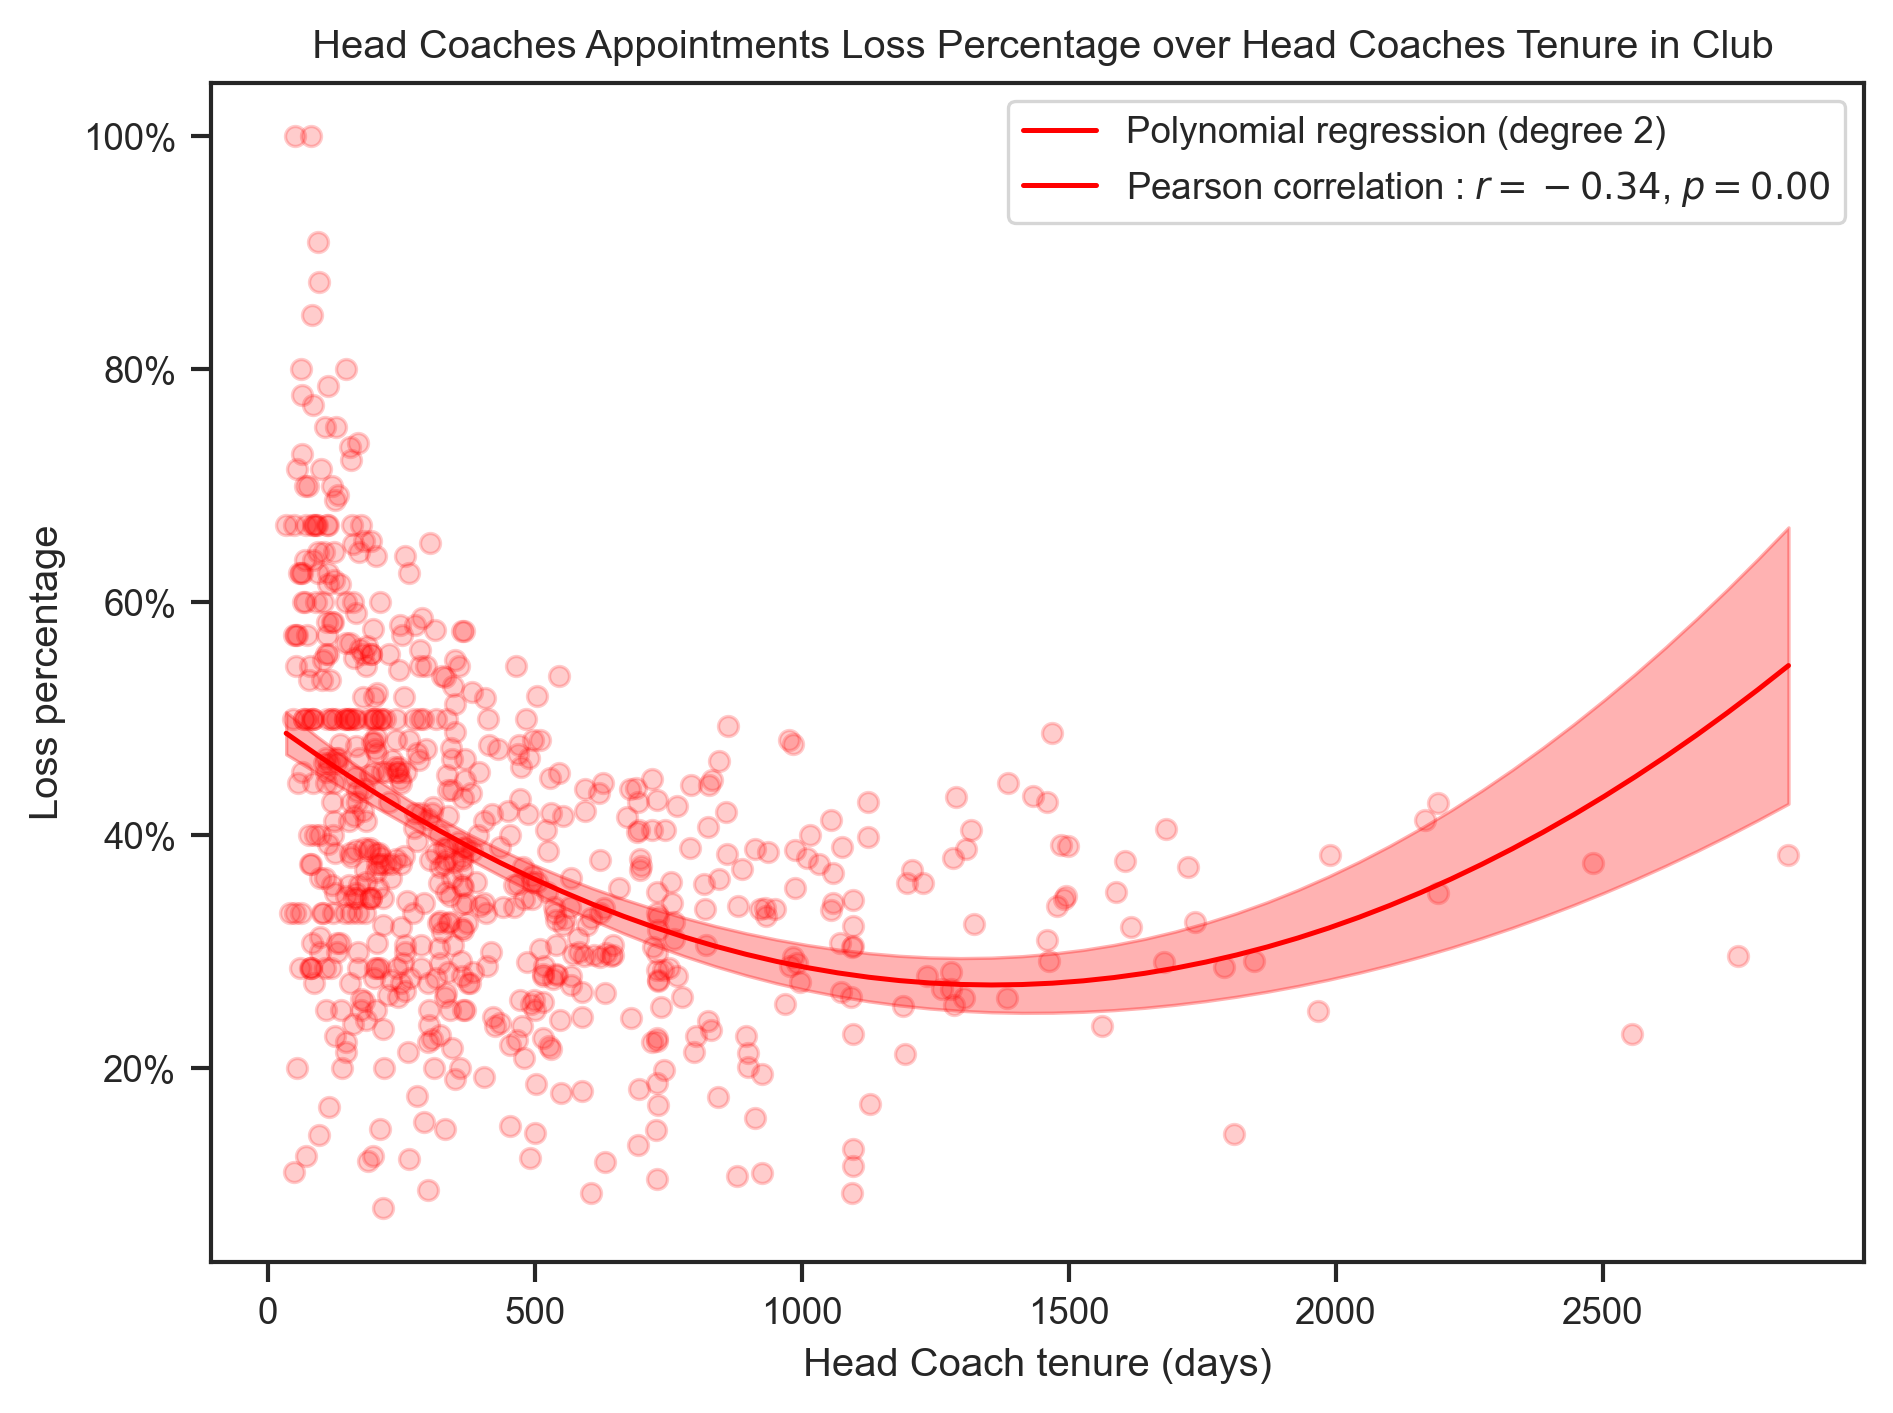

In [760]:
#| label: hc_loss_ratio_over_days
create_polynomial_regression_plot(head_coach, 'Tenure', 'LossPercentage', 'Loss', 'red', title.format('Loss'), x_label, degree=2)

#### Relation between Clubs Results and Number of Head Coaches

In [761]:
club_results = head_coach.groupby('Team').agg({'Wins': 'sum', 'Draws': 'sum', 'Losses': 'sum', 'Matches': 'sum', 'HeadCoach': 'count'})
club_results = club_results.rename(columns={'HeadCoach': 'CoachCount'})
club_results['WinPercentage'] = club_results['Wins'] / club_results['Matches'] * 100
club_results['DrawPercentage'] = club_results['Draws'] / club_results['Matches'] * 100
club_results['LossPercentage'] = club_results['Losses'] / club_results['Matches'] * 100

title = 'Clubs {} Percentage versus Number of Head Coaches Club Had (2015-2023)'
x_label = 'Number of coach seen by club'

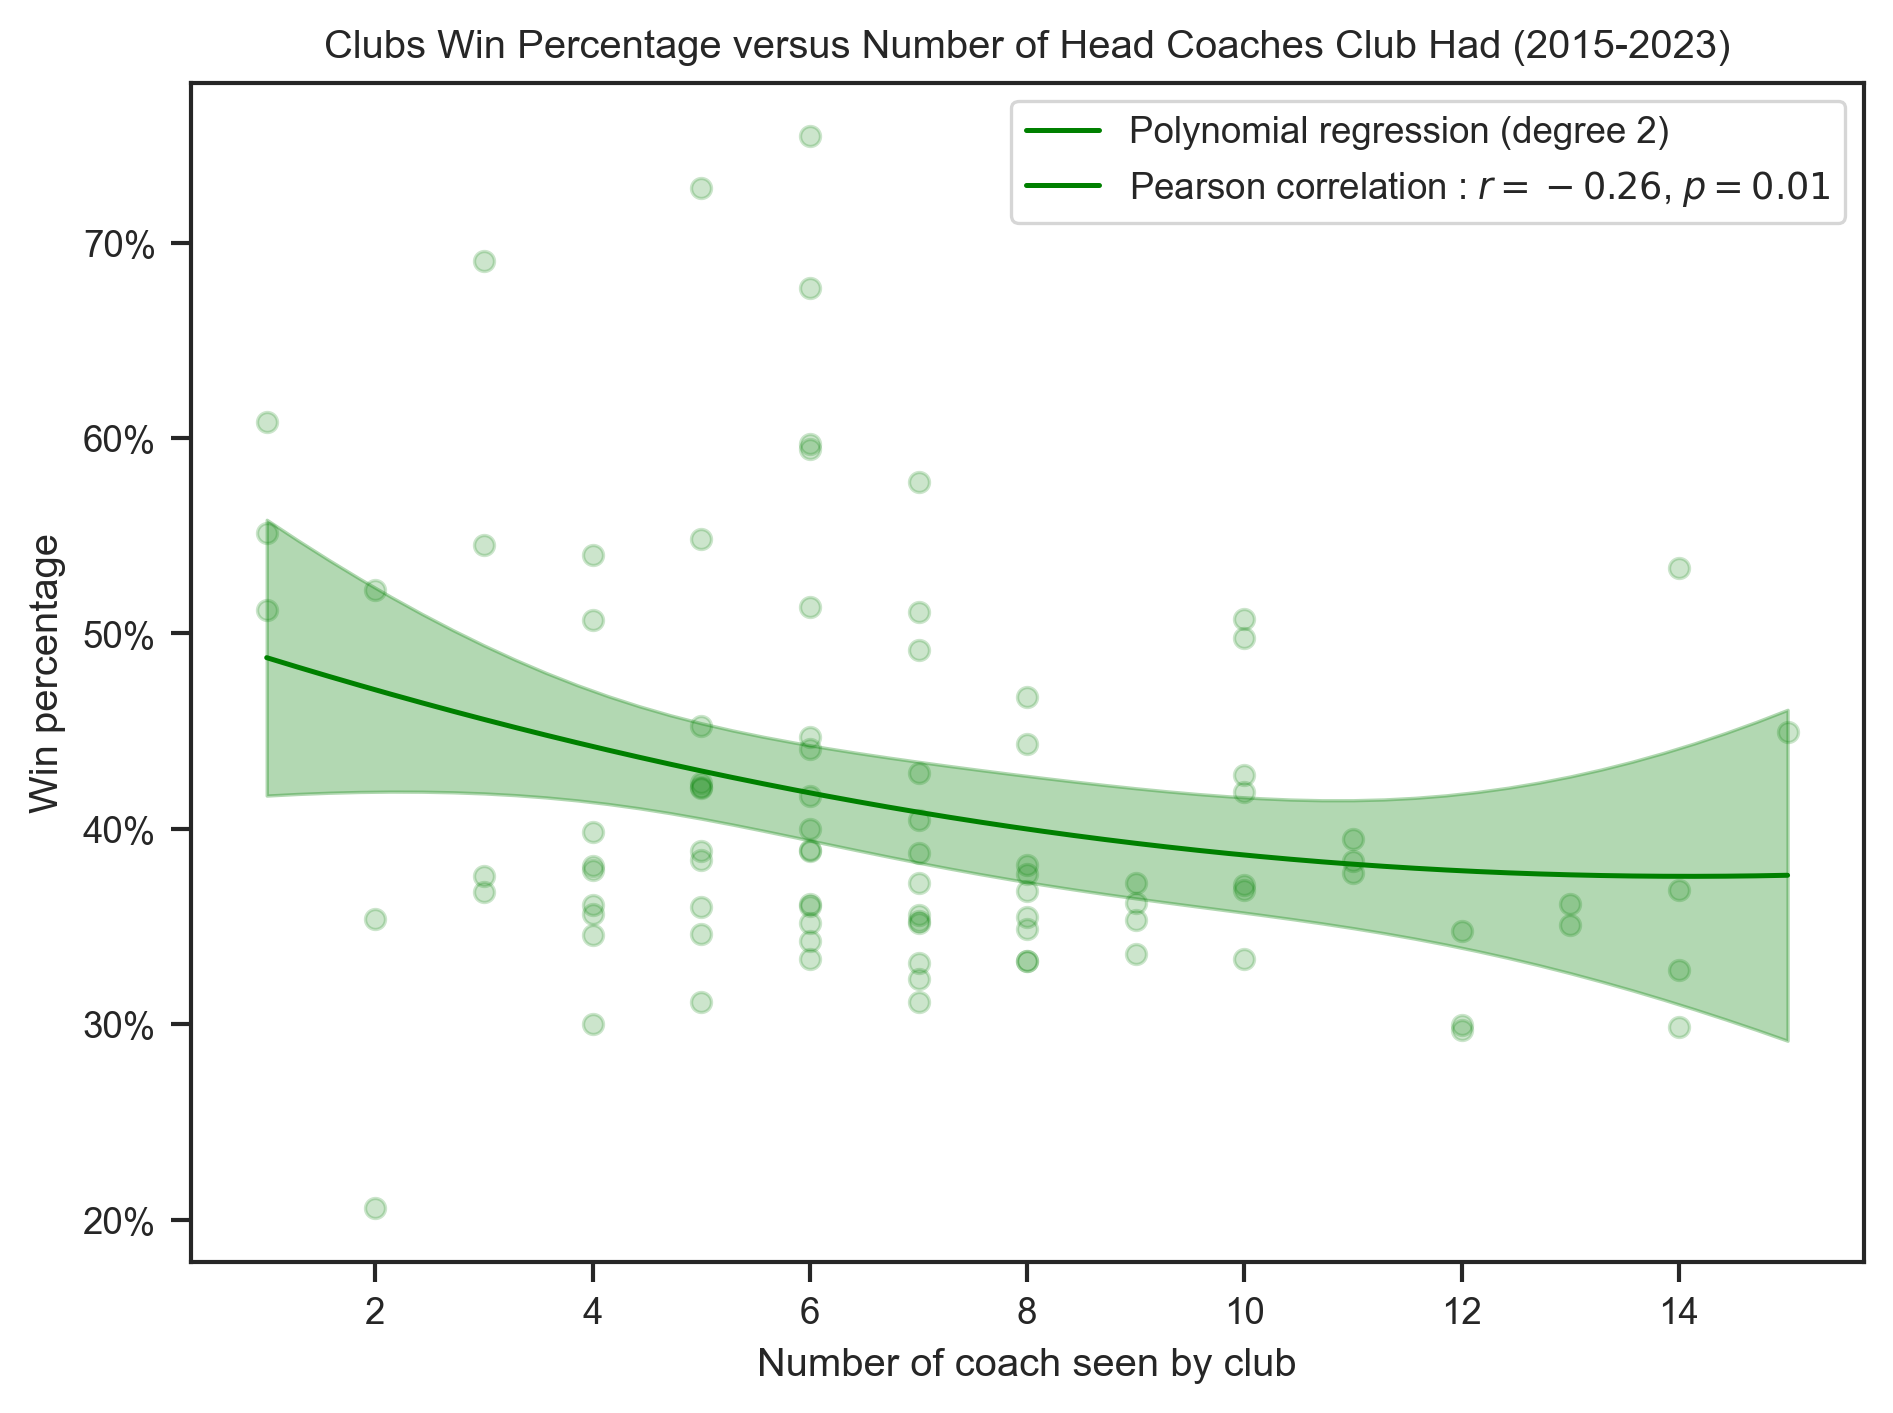

In [762]:
#| label: club_win_ratio_over_coach_count
create_polynomial_regression_plot(club_results, 'CoachCount', 'WinPercentage', 'Win', 'green', title.format('Win'), x_label, degree=2)

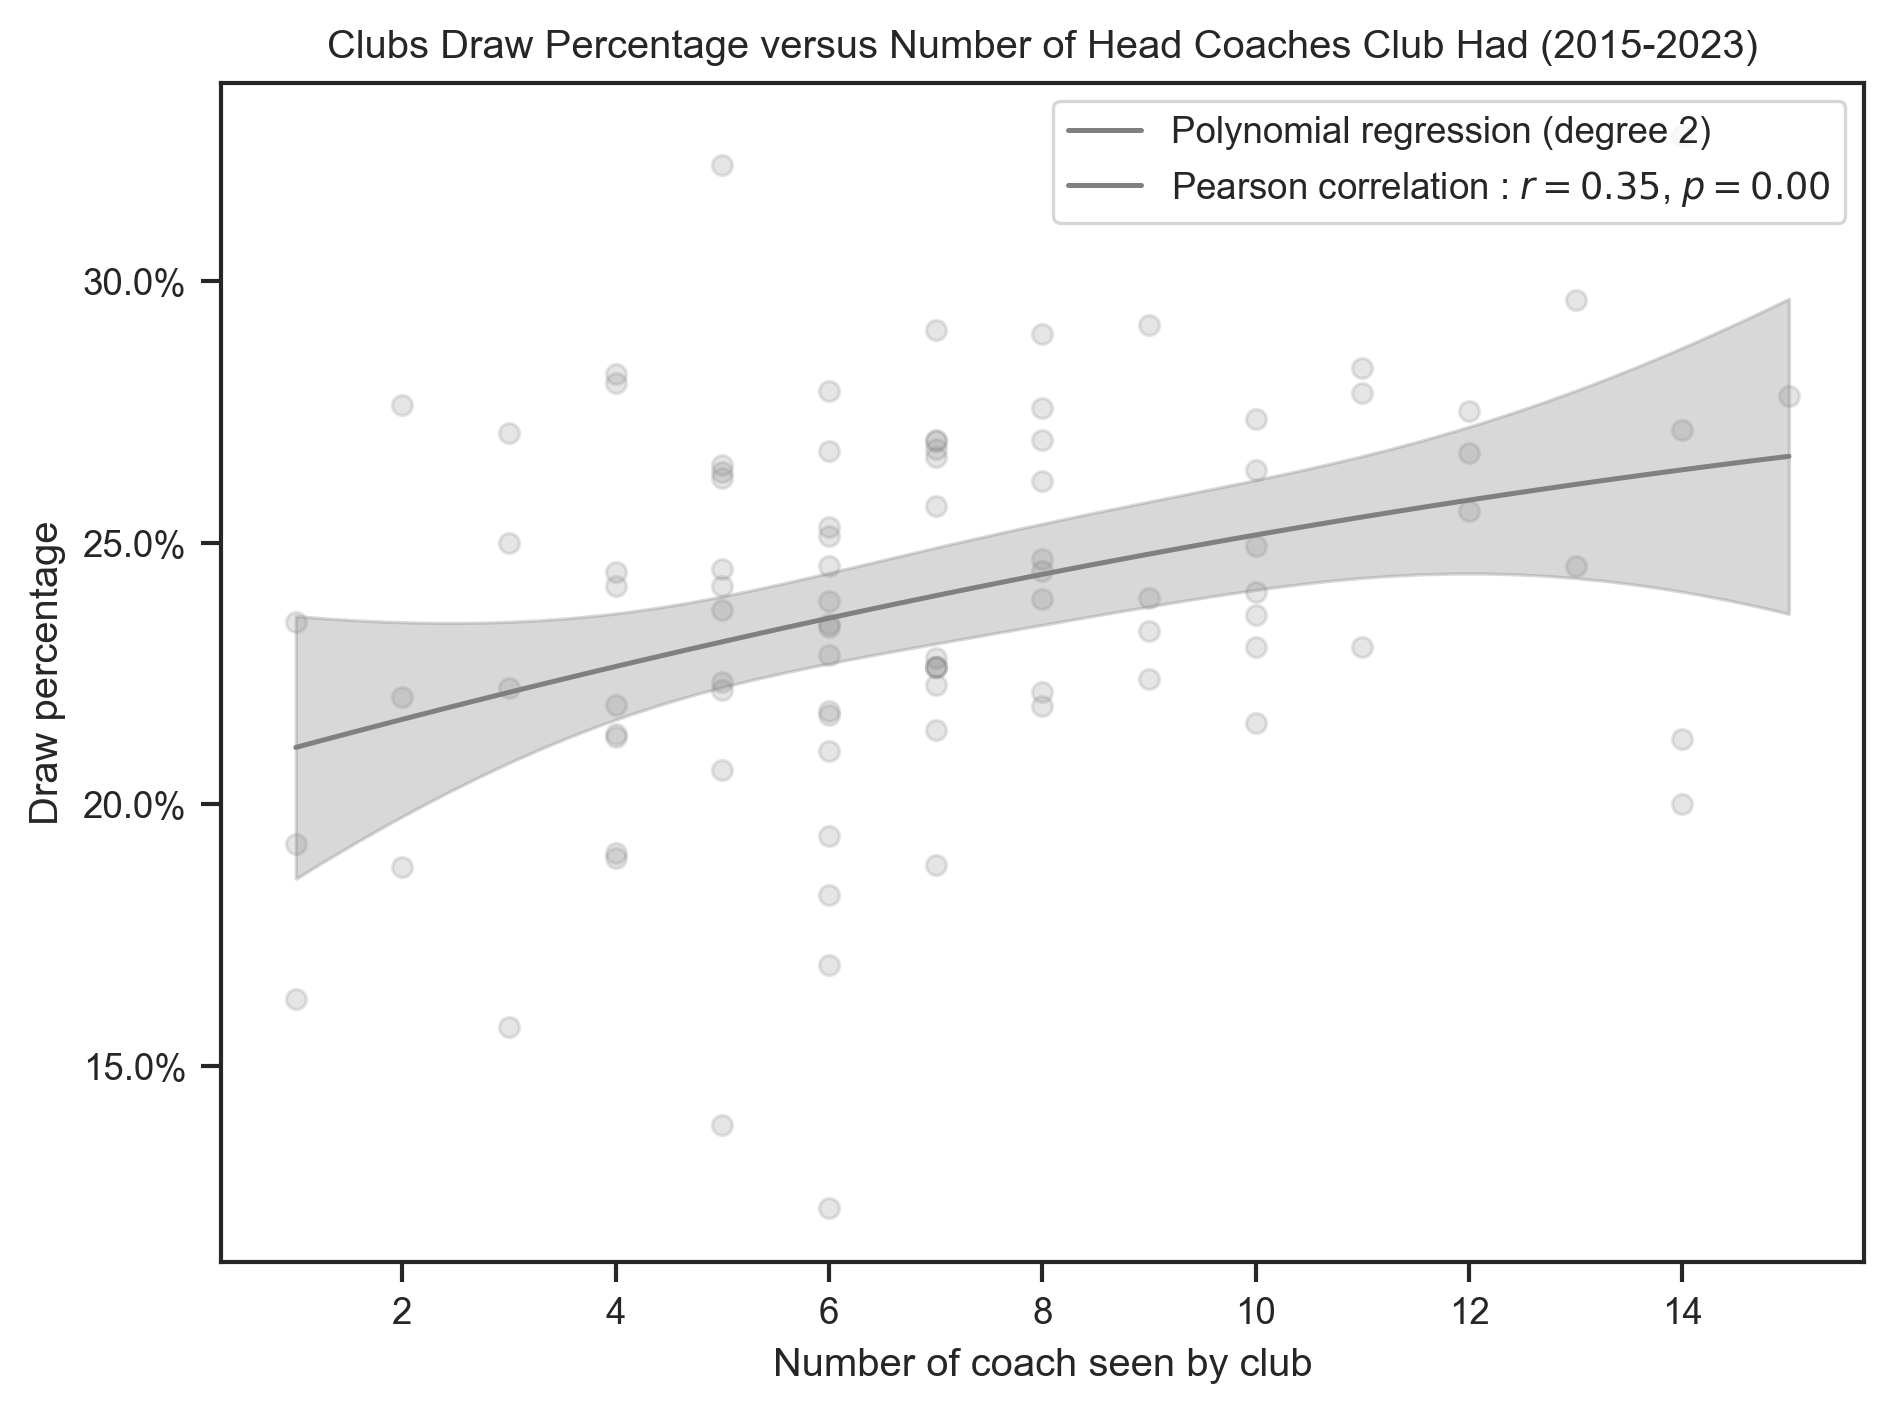

In [763]:
#| label: club_draw_ratio_over_coach_count
create_polynomial_regression_plot(club_results, 'CoachCount', 'DrawPercentage', 'Draw', 'gray', title.format('Draw'), x_label, degree=2)

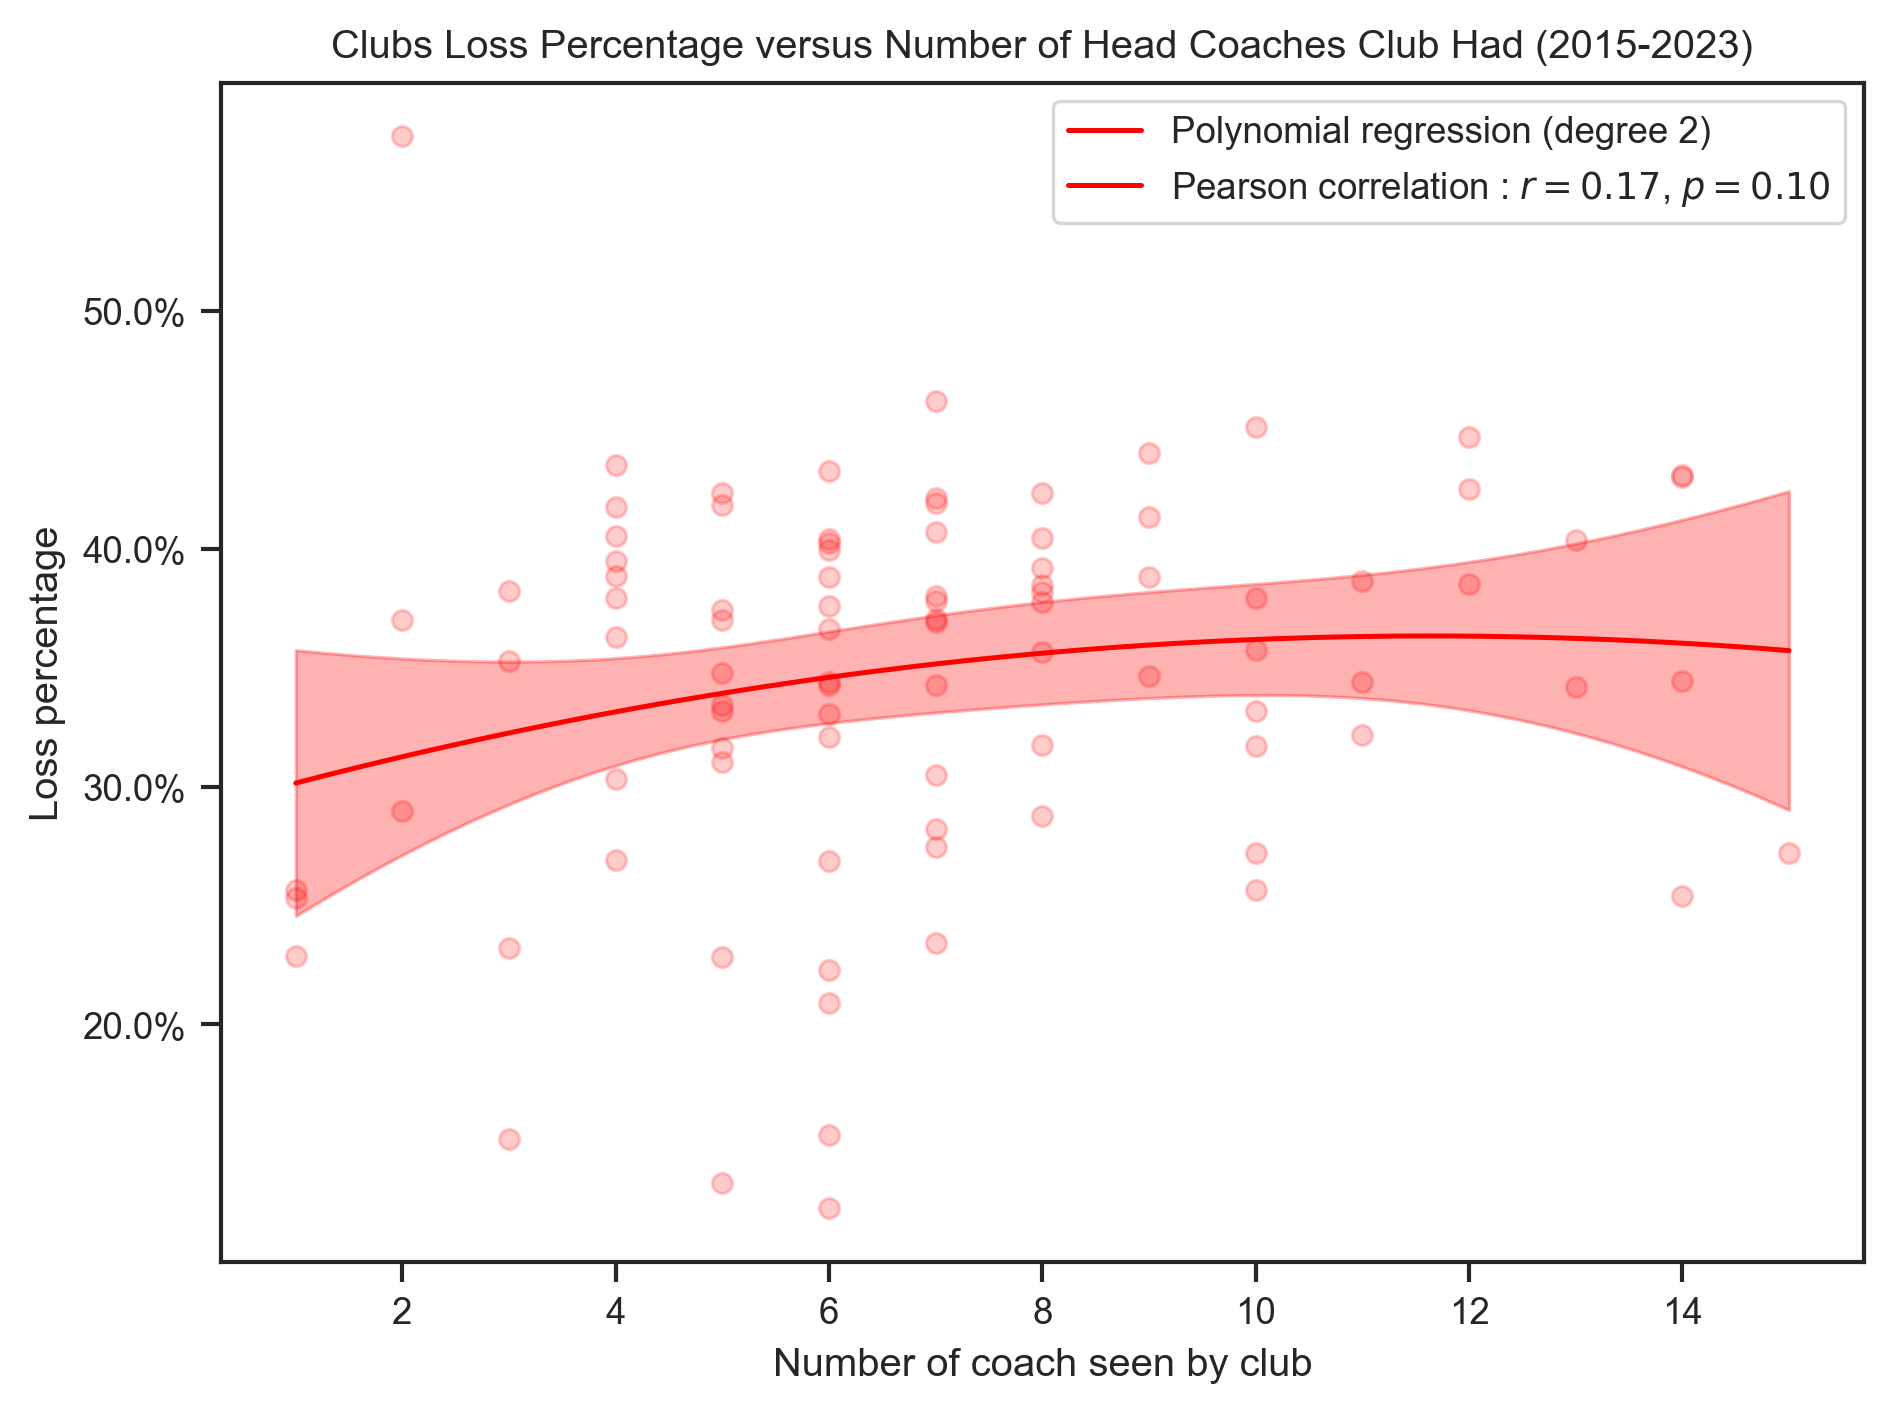

In [764]:
#| label: club_loss_ratio_over_coach_count
create_polynomial_regression_plot(club_results, 'CoachCount', 'LossPercentage', 'Loss', 'red', title.format('Loss'), x_label, degree=2)

#### Relation between Head Coach Aggregated Performance versus Total Number of Clubs Head Coaches Worked for

In [765]:
head_coach.groupby('HeadCoach').agg({'Matches': 'sum', 'Wins': 'sum', 'Draws': 'sum', 'Losses': 'sum', 'Team': 'count'}).reset_index().sort_values('Team')

# Investigate why we have Team count = 0 for some head coaches
head_coach.groupby('HeadCoach').agg({'Matches': 'count'}).reset_index().sort_values('Matches')

# Is there Head Coach with no team?
head_coach[head_coach['Team'].isnull()]

Team League Country             HeadCoach  Appointed    EndDate  Tenure  \
16   NaN    NaN     NaN        Albert Cartier 2017-05-30 2018-10-09     497   
30   NaN    NaN     NaN      Alfredo Aglietti 2020-03-01 2021-06-30     486   
121  NaN    NaN     NaN     David Ducourtioux 2020-05-25 2022-06-30     766   
156  NaN    NaN     NaN     Domenico Di Carlo 2018-11-13 2019-05-31     199   
197  NaN    NaN     NaN    François Ciccolini 2019-06-18 2020-05-15     332   
239  NaN    NaN     NaN  Hervé Della Maggiore 2018-10-15 2019-06-16     244   
263  NaN    NaN     NaN     Jean-Luc Vannuchi 2016-07-01 2017-05-26     329   
322  NaN    NaN     NaN        Lorenzo D'Anna 2018-04-29 2018-10-09     163   
408  NaN    NaN     NaN     Michele Marcolini 2019-07-04 2020-03-01     241   
526  NaN    NaN     NaN         Rolando Maran 2014-10-19 2018-04-29    1288   
607  NaN    NaN     NaN        Thierry Laurey 2013-02-19 2016-06-30    1227   

     Matches  Wins  Draws  Losses  AppointmentNumber  WinPercentage  \
16        54    17     11      26                  1      31.481481   
30        55    20     19      16                  2      36.363636   
121       43    21     10      12                  1      48.837209   
156       27     2     11      14                  1       7.407407   
197       28     5      8      15                  2      17.857143   
239       33     9      9      15                  1      27.272727   
263       40    13     12      15                  1      32.500000   
322       12     4      2       6                  1      33.333333   
408       28    10     10       8                  1      35.714286   
526      148    44     40      64                  1      29.729730   
607      131    49     35      47                  1      37.404580   

     DrawPercentage  LossPercentage  
16        20.370370       48.148148  
30        34.545455       29.090909  
121       23.255814       27.906977  
156       40.740741       51.851852  
197       28.571429       53.571429  
239       27.272727       45.454545  
263       30.000000       37.500000  
322       16.666667       50.000000  
408       35.714286       28.571429  
526       27.027027       43.243243  
607       26.717557       35.877863

In [766]:
# Plot of wins, draw and losses percentage over number of club head coach has been

hc_results = head_coach.groupby('HeadCoach').agg({'Matches': 'sum', 'Wins': 'sum', 'Draws': 'sum', 'Losses': 'sum', 'Team': 'count'}).reset_index()
hc_results = hc_results.rename(columns={'Team': 'ClubCount'})
hc_results['WinPercentage'] = hc_results['Wins'] / hc_results['Matches'] * 100
hc_results['DrawPercentage'] = hc_results['Draws'] / hc_results['Matches'] * 100
hc_results['LossPercentage'] = hc_results['Losses'] / hc_results['Matches'] * 100

title = 'Head Coach Aggregated {} Percentage versus Total Number of Clubs Head Coaches Worked for'
x_label = 'Number of clubs Head Coach have worked for'

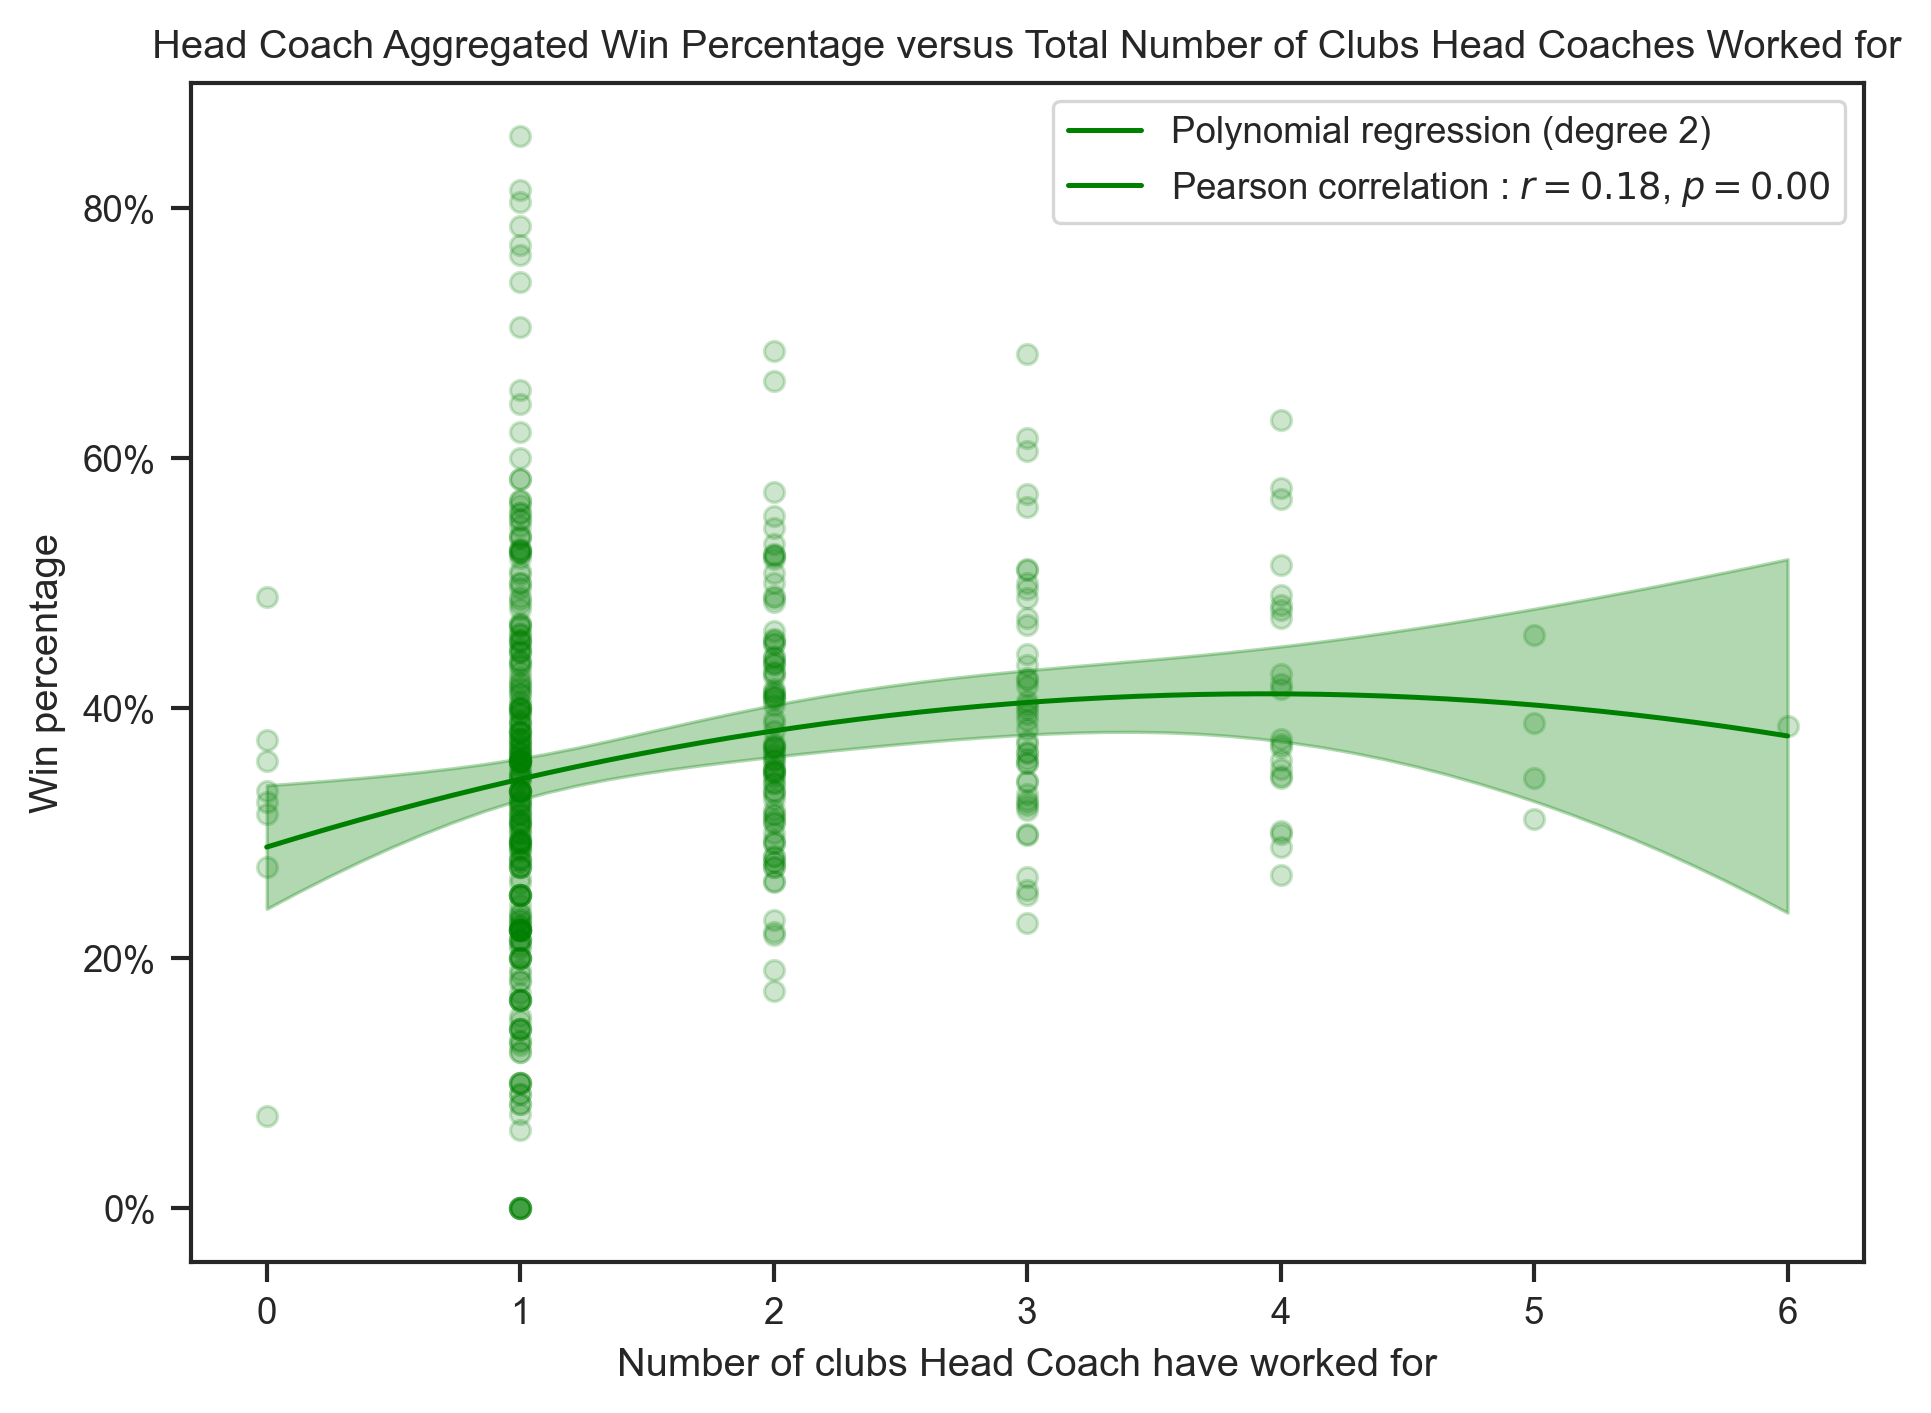

In [767]:
#| label: hc_win_ratio_over_club_count
create_polynomial_regression_plot(hc_results, 'ClubCount', 'WinPercentage', 'Win', 'green', title.format('Win'), x_label, degree=2)

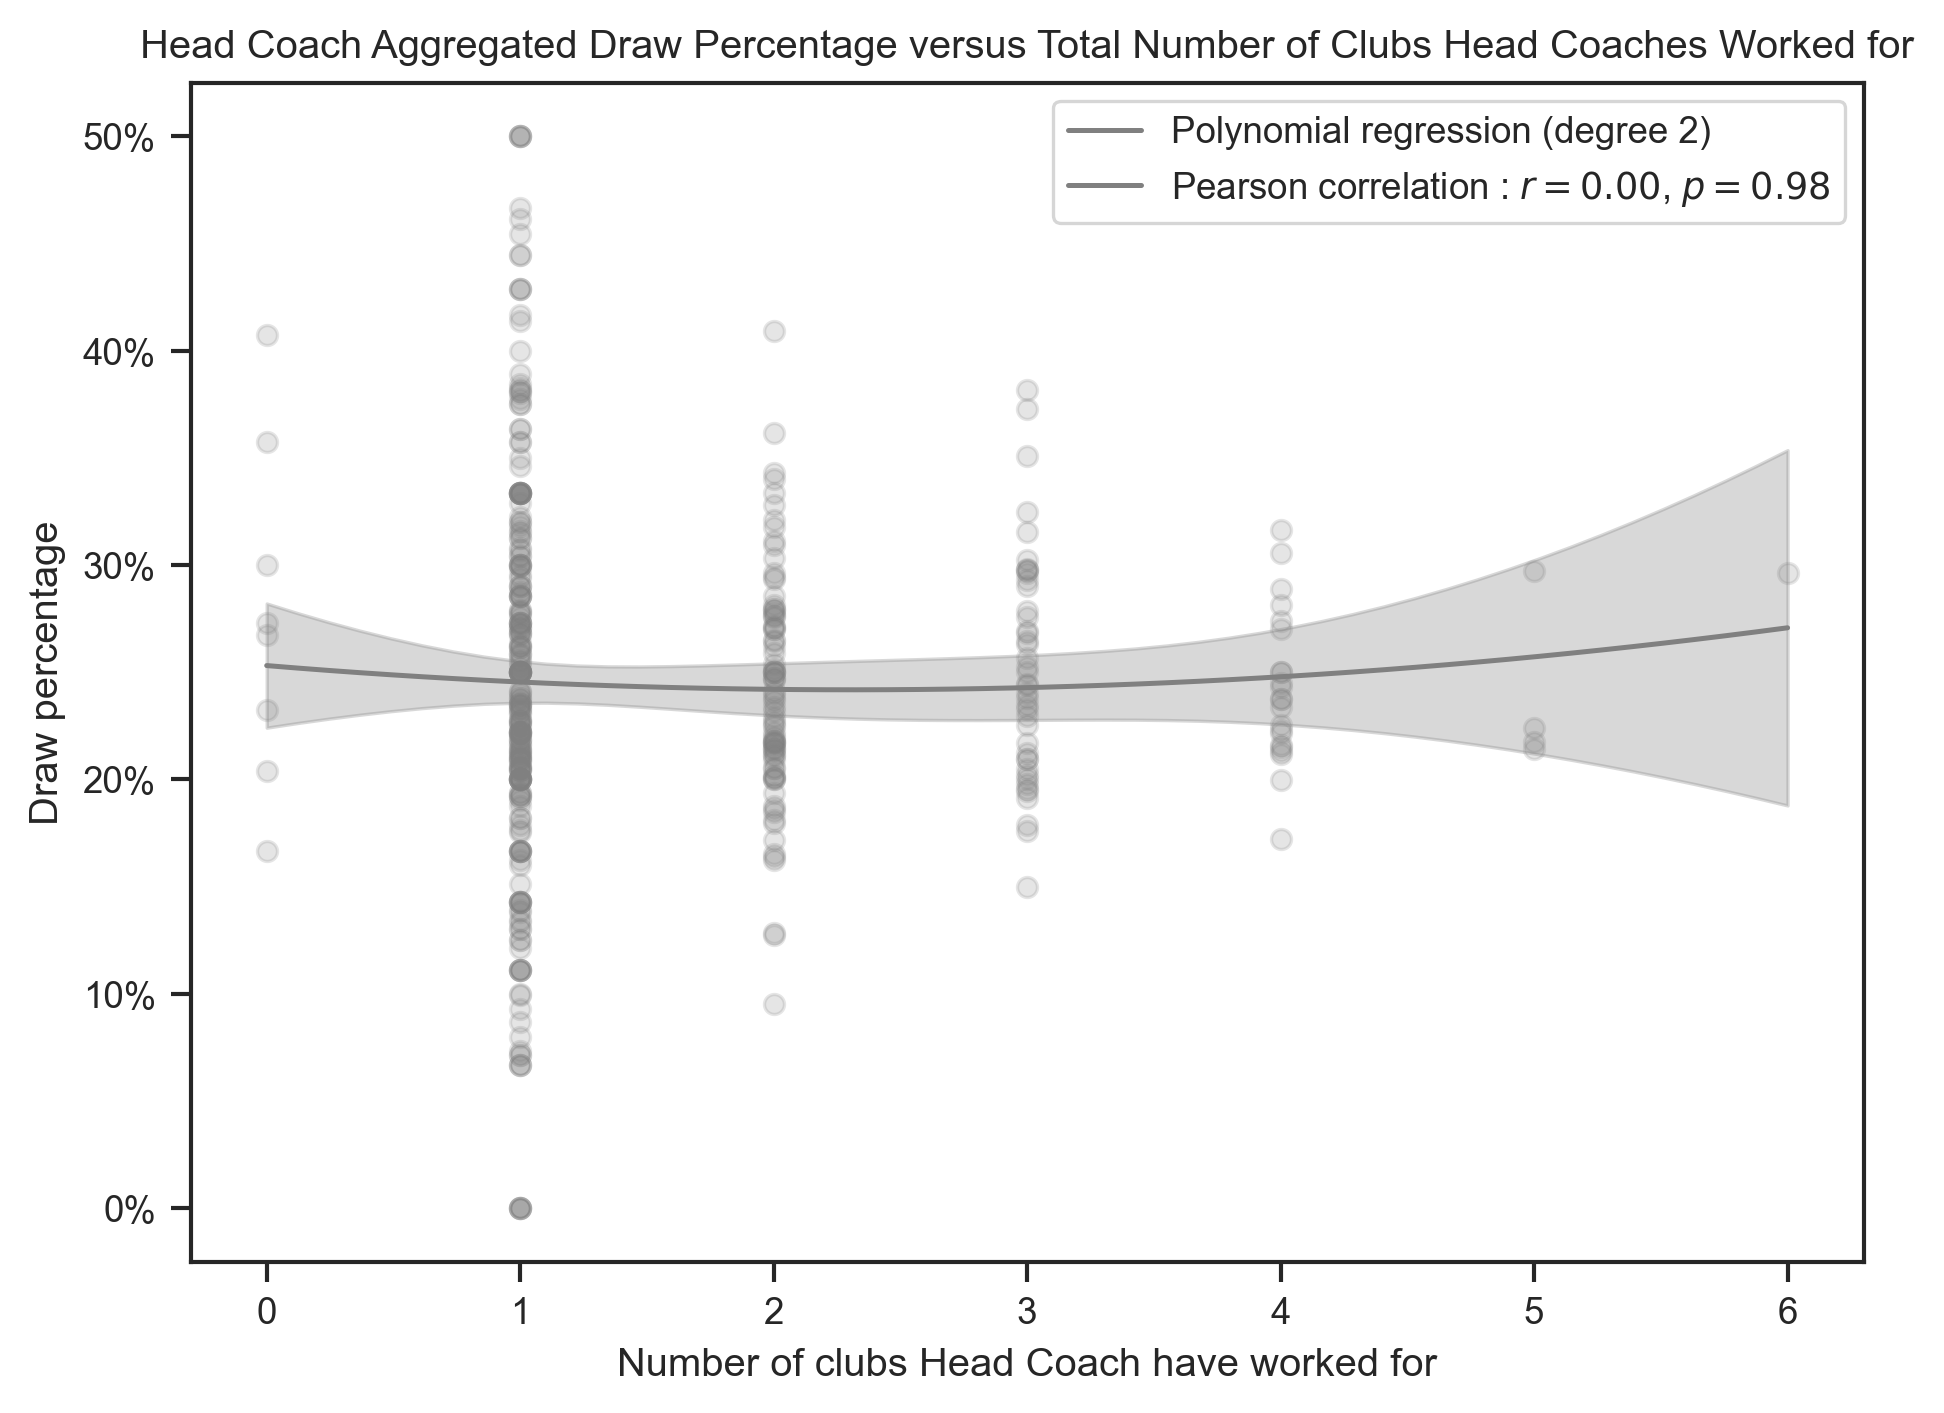

In [768]:
#| label: hc_draw_ratio_over_club_count
create_polynomial_regression_plot(hc_results, 'ClubCount', 'DrawPercentage', 'Draw', 'gray', title.format('Draw'), x_label, degree=2)

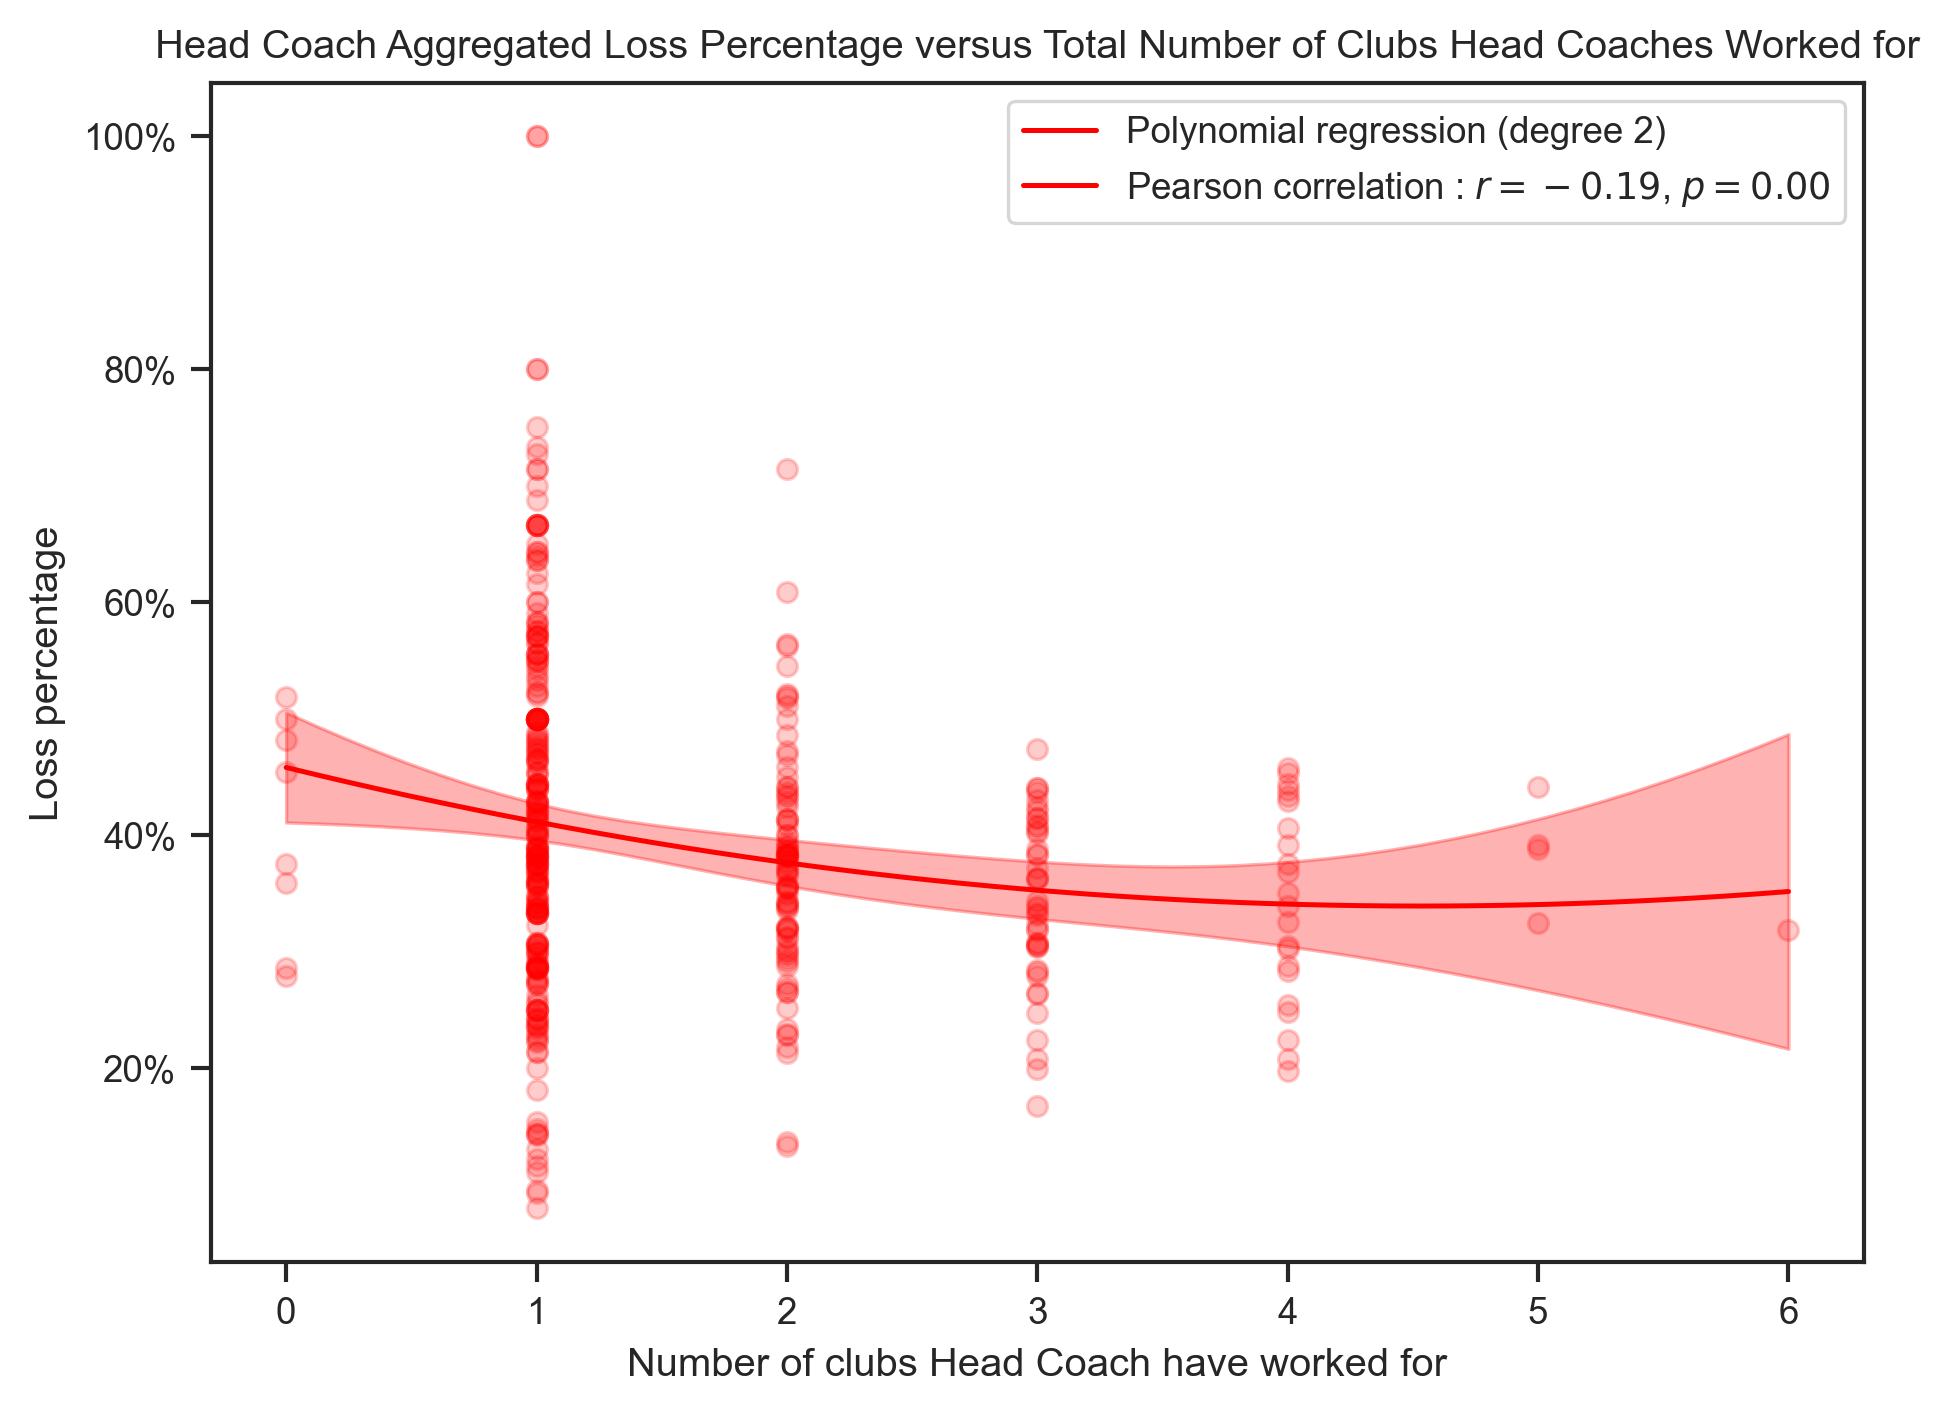

In [769]:
#| label: hc_loss_ratio_over_club_count
create_polynomial_regression_plot(hc_results, 'ClubCount', 'LossPercentage', 'Loss', 'red', title.format('Loss'), x_label, degree=2)

#### Relation between Head Coach Appointments Results versus Head Coach Appointments Counts

In [770]:
title = f'Head Coach Appointments Results versus Head Coach Appointments Count'
x_label = 'Appointment Count'

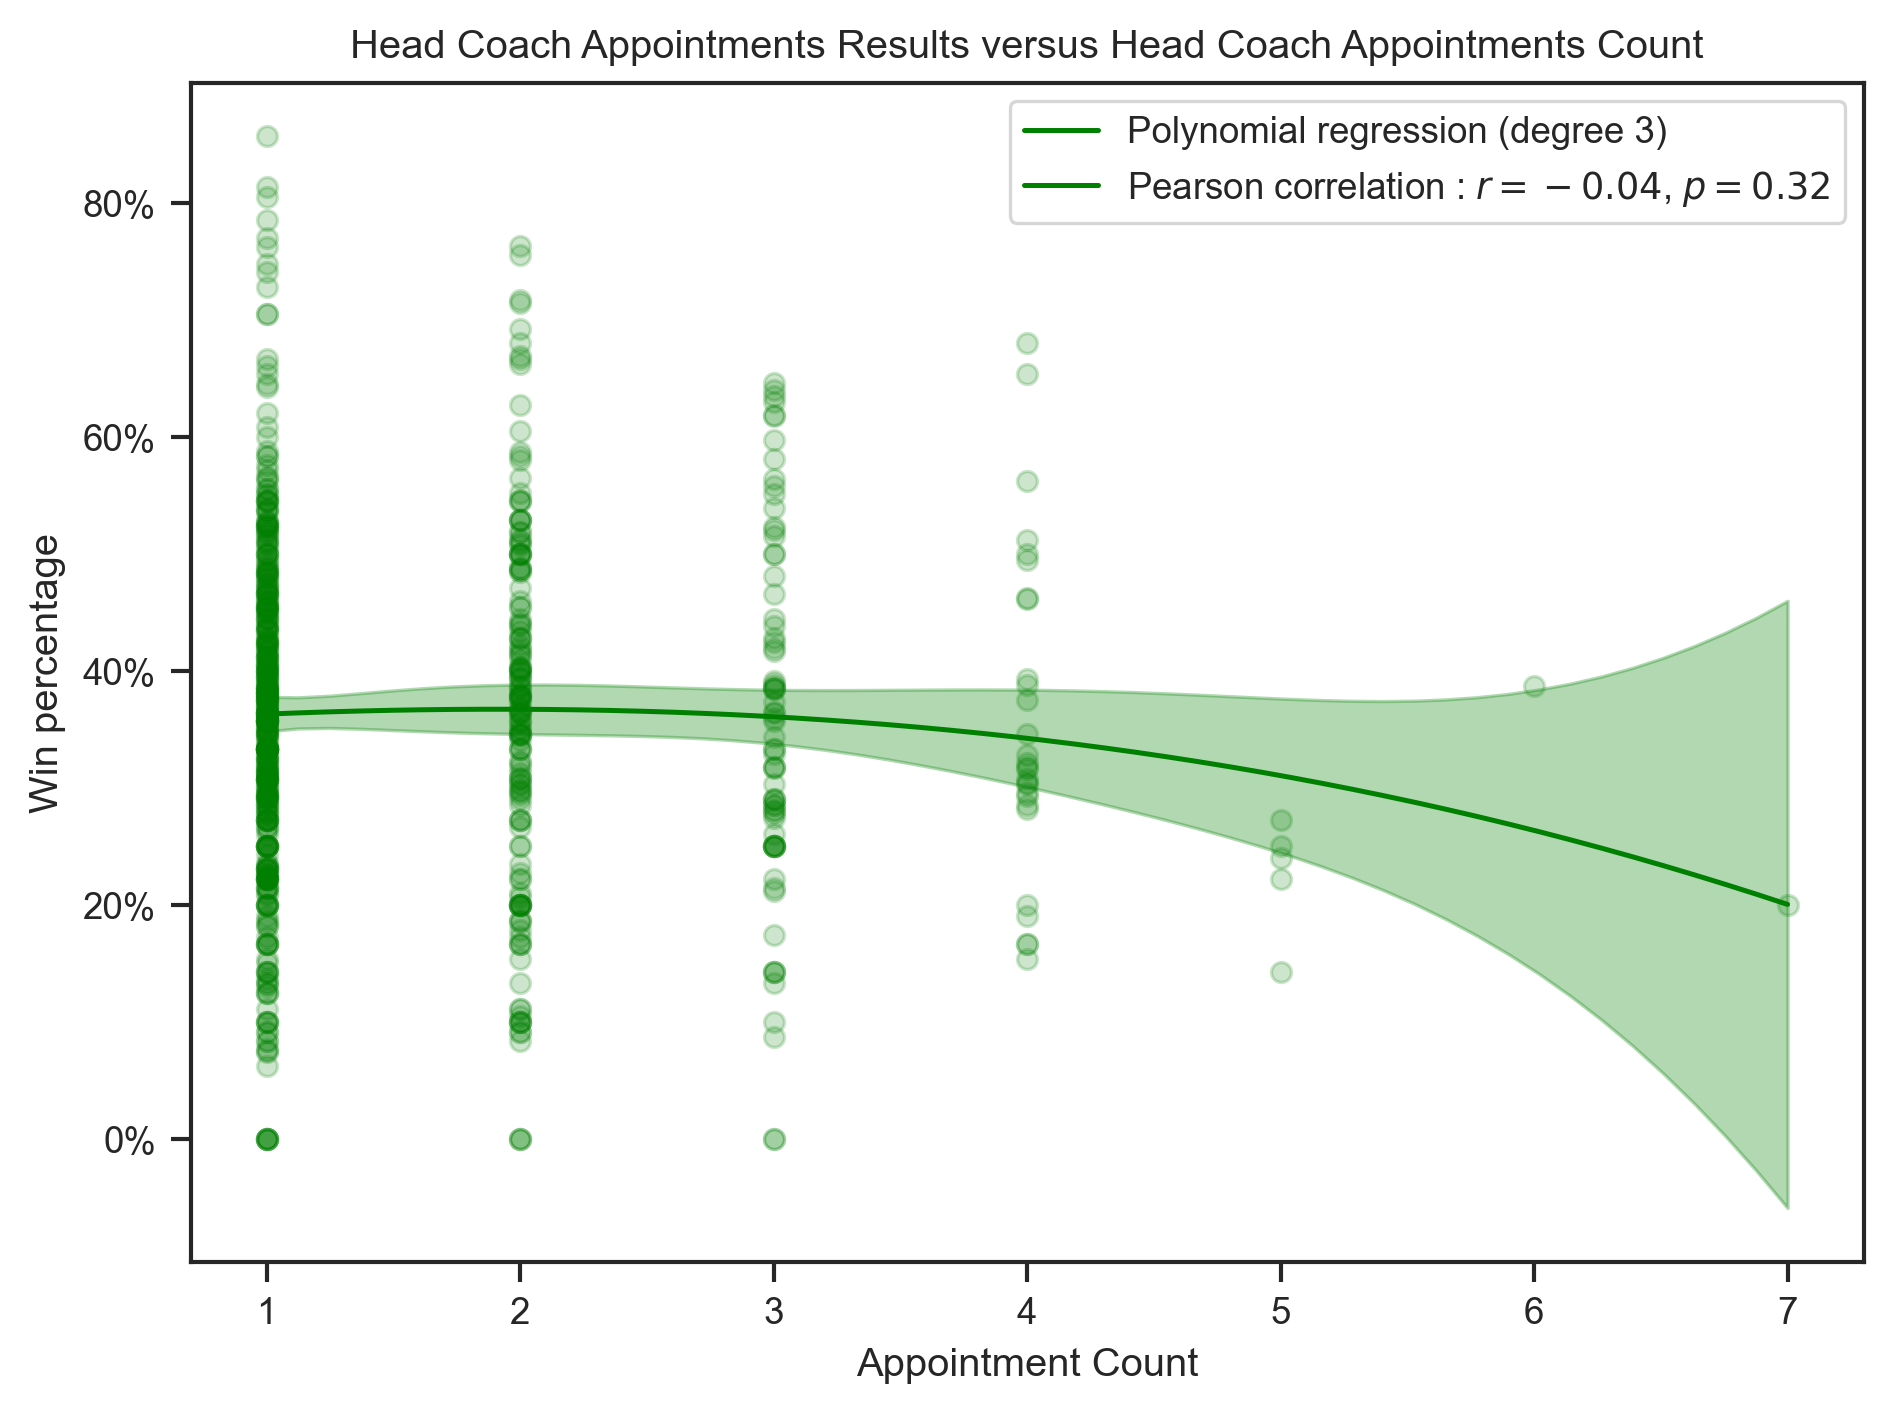

In [771]:
#| label: hc_win_vs_appointment_count
create_polynomial_regression_plot(head_coach, 'AppointmentNumber', 'WinPercentage', 'Win', 'green', title, x_label, degree=3)

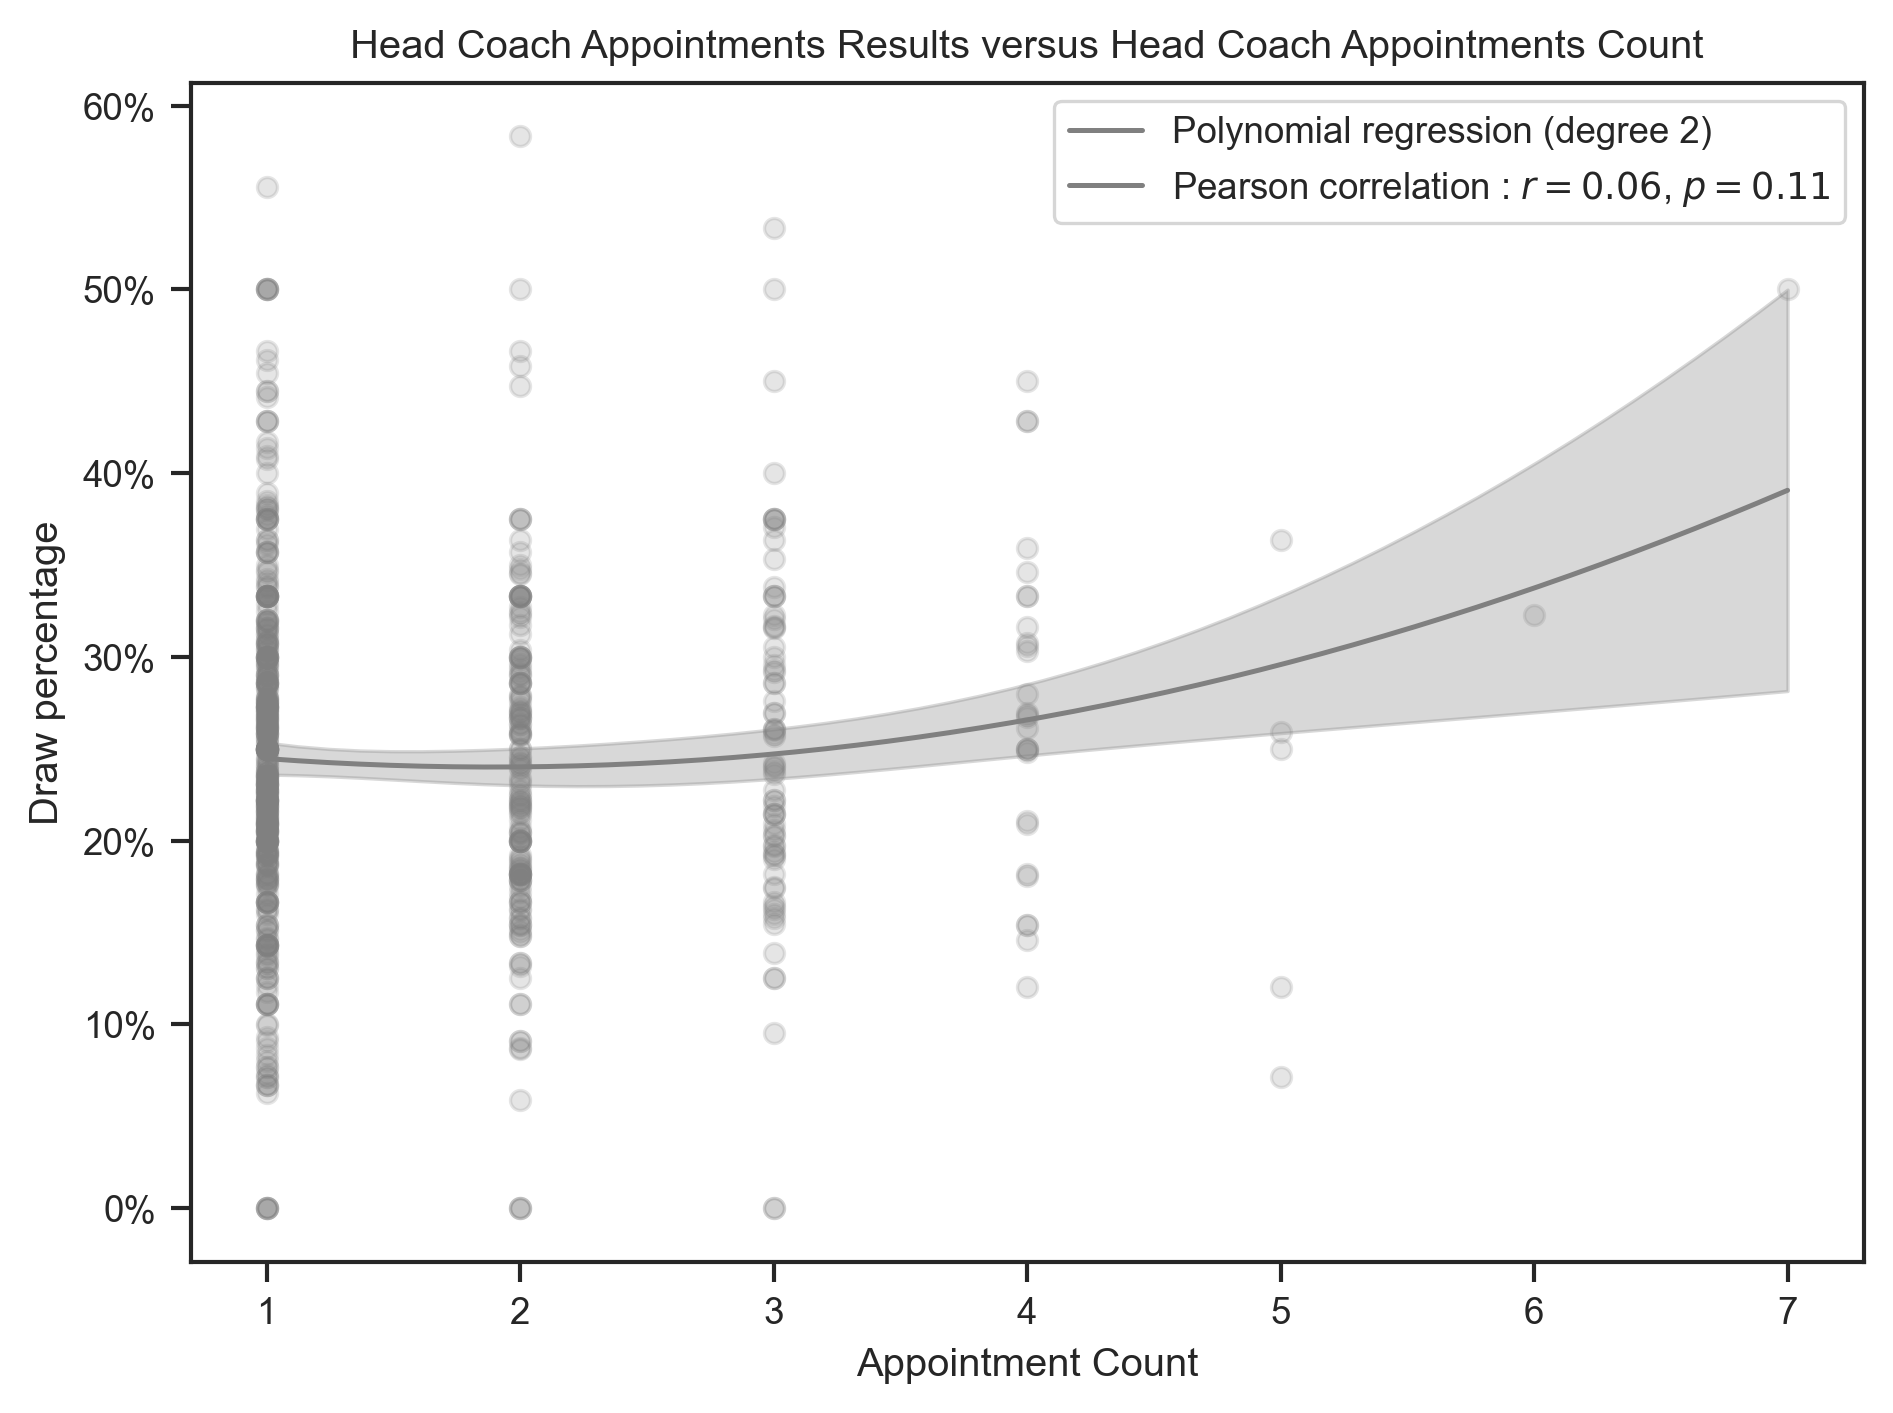

In [772]:
#| label: hc_draw_vs_appointment_count
create_polynomial_regression_plot(head_coach, 'AppointmentNumber', 'DrawPercentage', 'Draw', 'gray', title, x_label, degree=2)

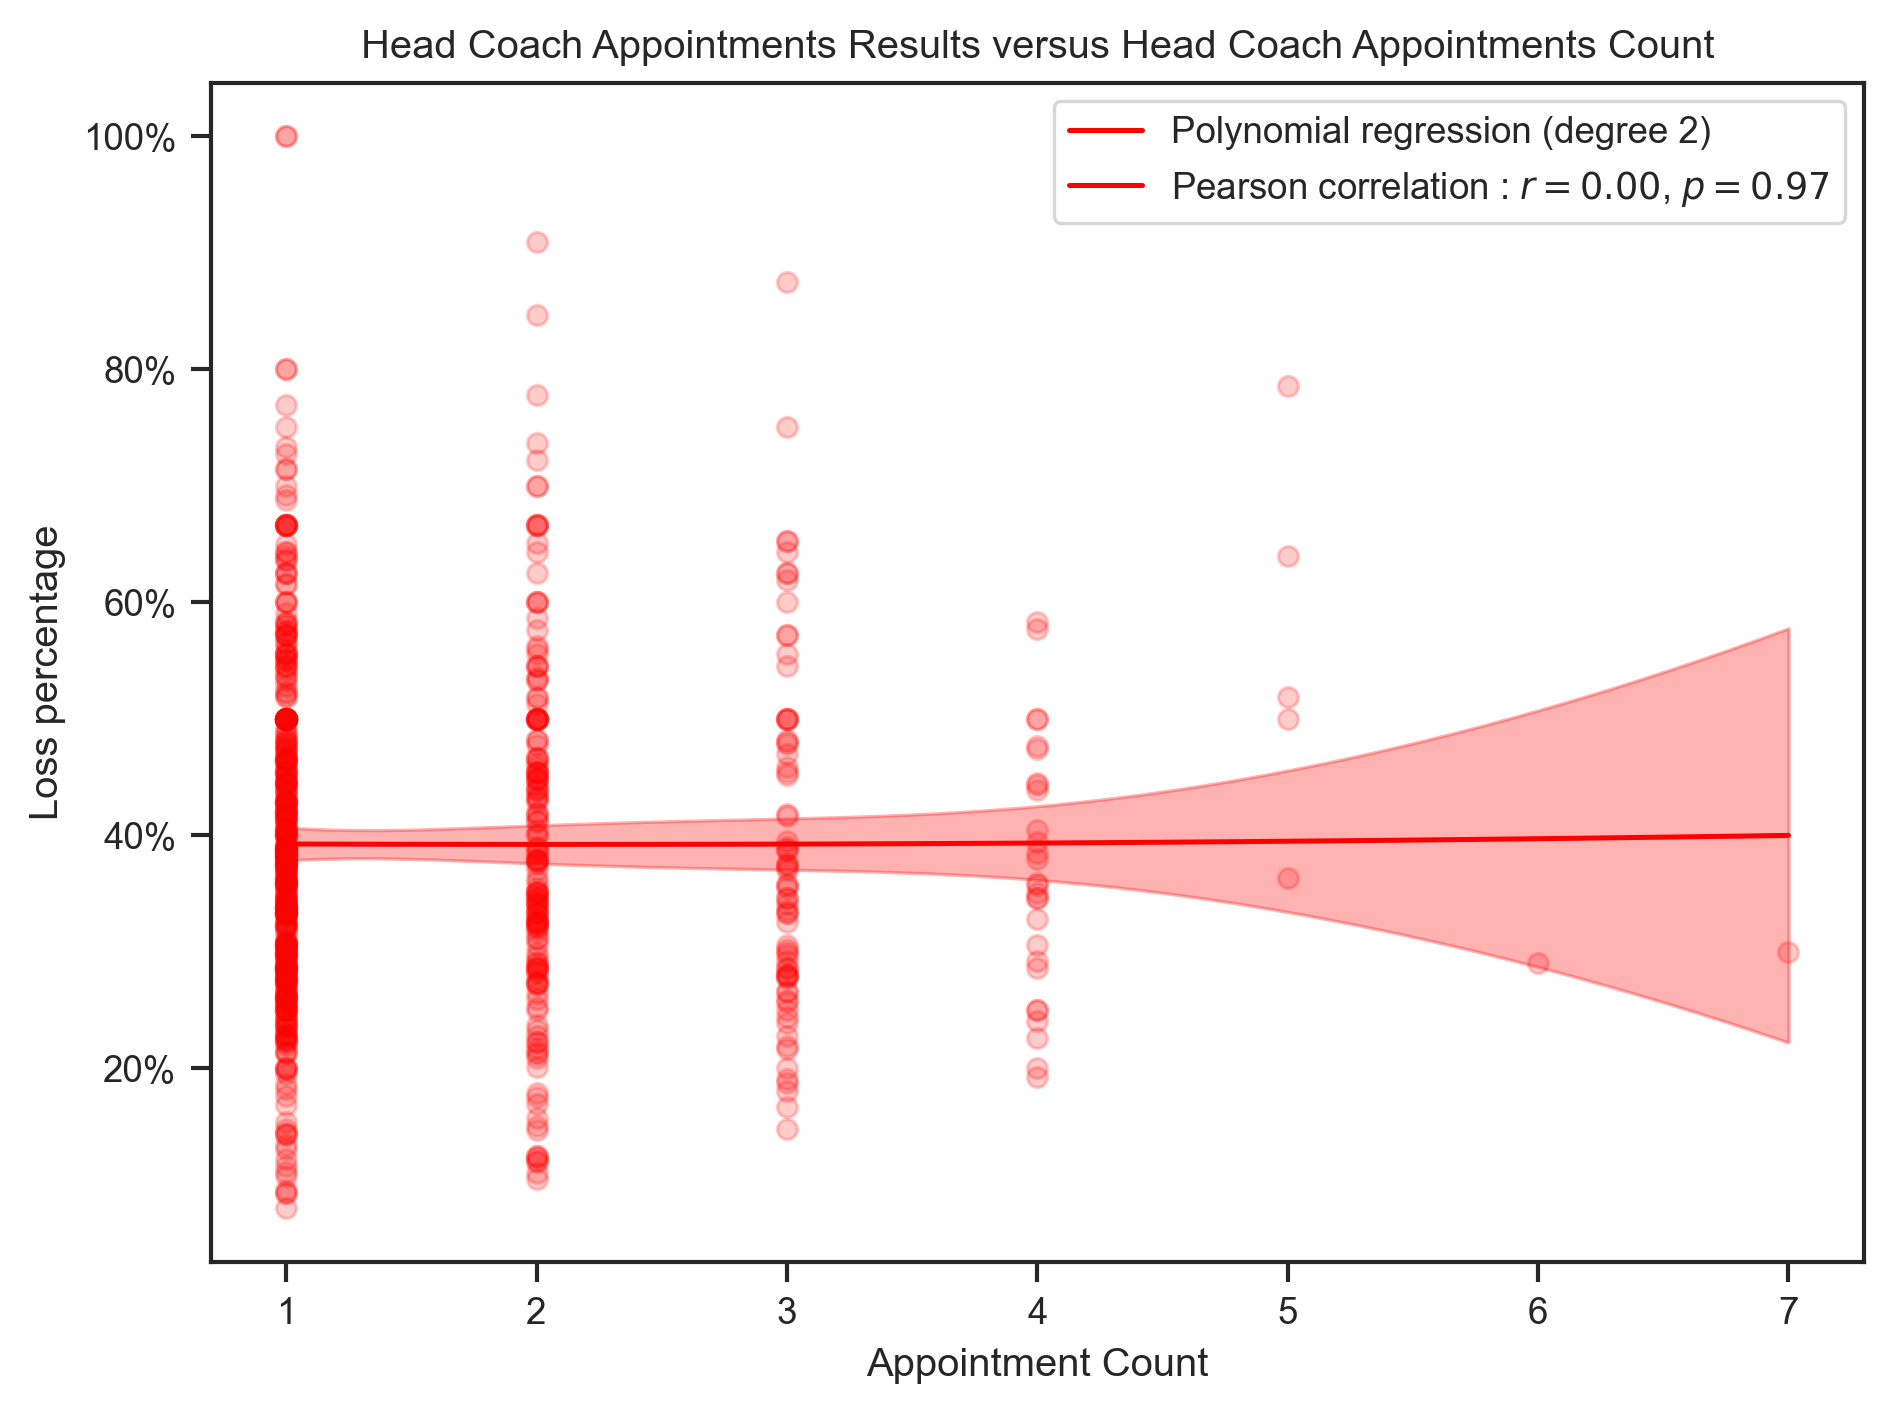

In [773]:
#| label: hc_loss_vs_appointment_count
create_polynomial_regression_plot(head_coach, 'AppointmentNumber', 'LossPercentage', 'Loss', 'red', title, x_label, degree=2)

### Loading data

In [774]:
#| label: joint_data
match_results = pd.read_csv('data/match_results.csv', parse_dates=['Date'], dtype = {'HeadCoach' : 'str'})
match_results.head()

League  Country       Date            Team  Goals Result  isHome  \
0  Premier League  England 2014-08-16  Manchester Utd    1.0   loss    True   
1  Premier League  England 2014-08-16      Stoke City    0.0   loss    True   
2  Premier League  England 2014-08-16  Leicester City    2.0   draw    True   
3  Premier League  England 2014-08-16         Arsenal    2.0    win    True   
4  Premier League  England 2014-08-17       Liverpool    2.0    win    True   

         HeadCoach  DaysInPost  
0   Louis van Gaal        33.0  
1      Mark Hughes       443.0  
2    Nigel Pearson      1005.0  
3    Arsène Wenger      6528.0  
4  Brendan Rodgers       777.0

In [775]:
# Exclude rows where don't have information about head coach days in post during match
match_results = match_results.dropna(subset=['DaysInPost'])
# Exclude rows with DaysInPost more than 4000
match_results = match_results[match_results['DaysInPost'] <= 4000]
# The reason for this is that we have records of Arsenal head coach Arsene Wenger who has been in post for 22 years.
# Our data start date for matches is 2015. This makes some matches start with a head coach tenure of 5000 days.

match_results['Win'] = match_results['Result'].apply(lambda x: 1 if x == 'win' else 0)
match_results['Loss'] = match_results['Result'].apply(lambda x: 1 if x == 'loss' else 0)
match_results['Draw'] = match_results['Result'].apply(lambda x: 1 if x == 'draw' else 0)

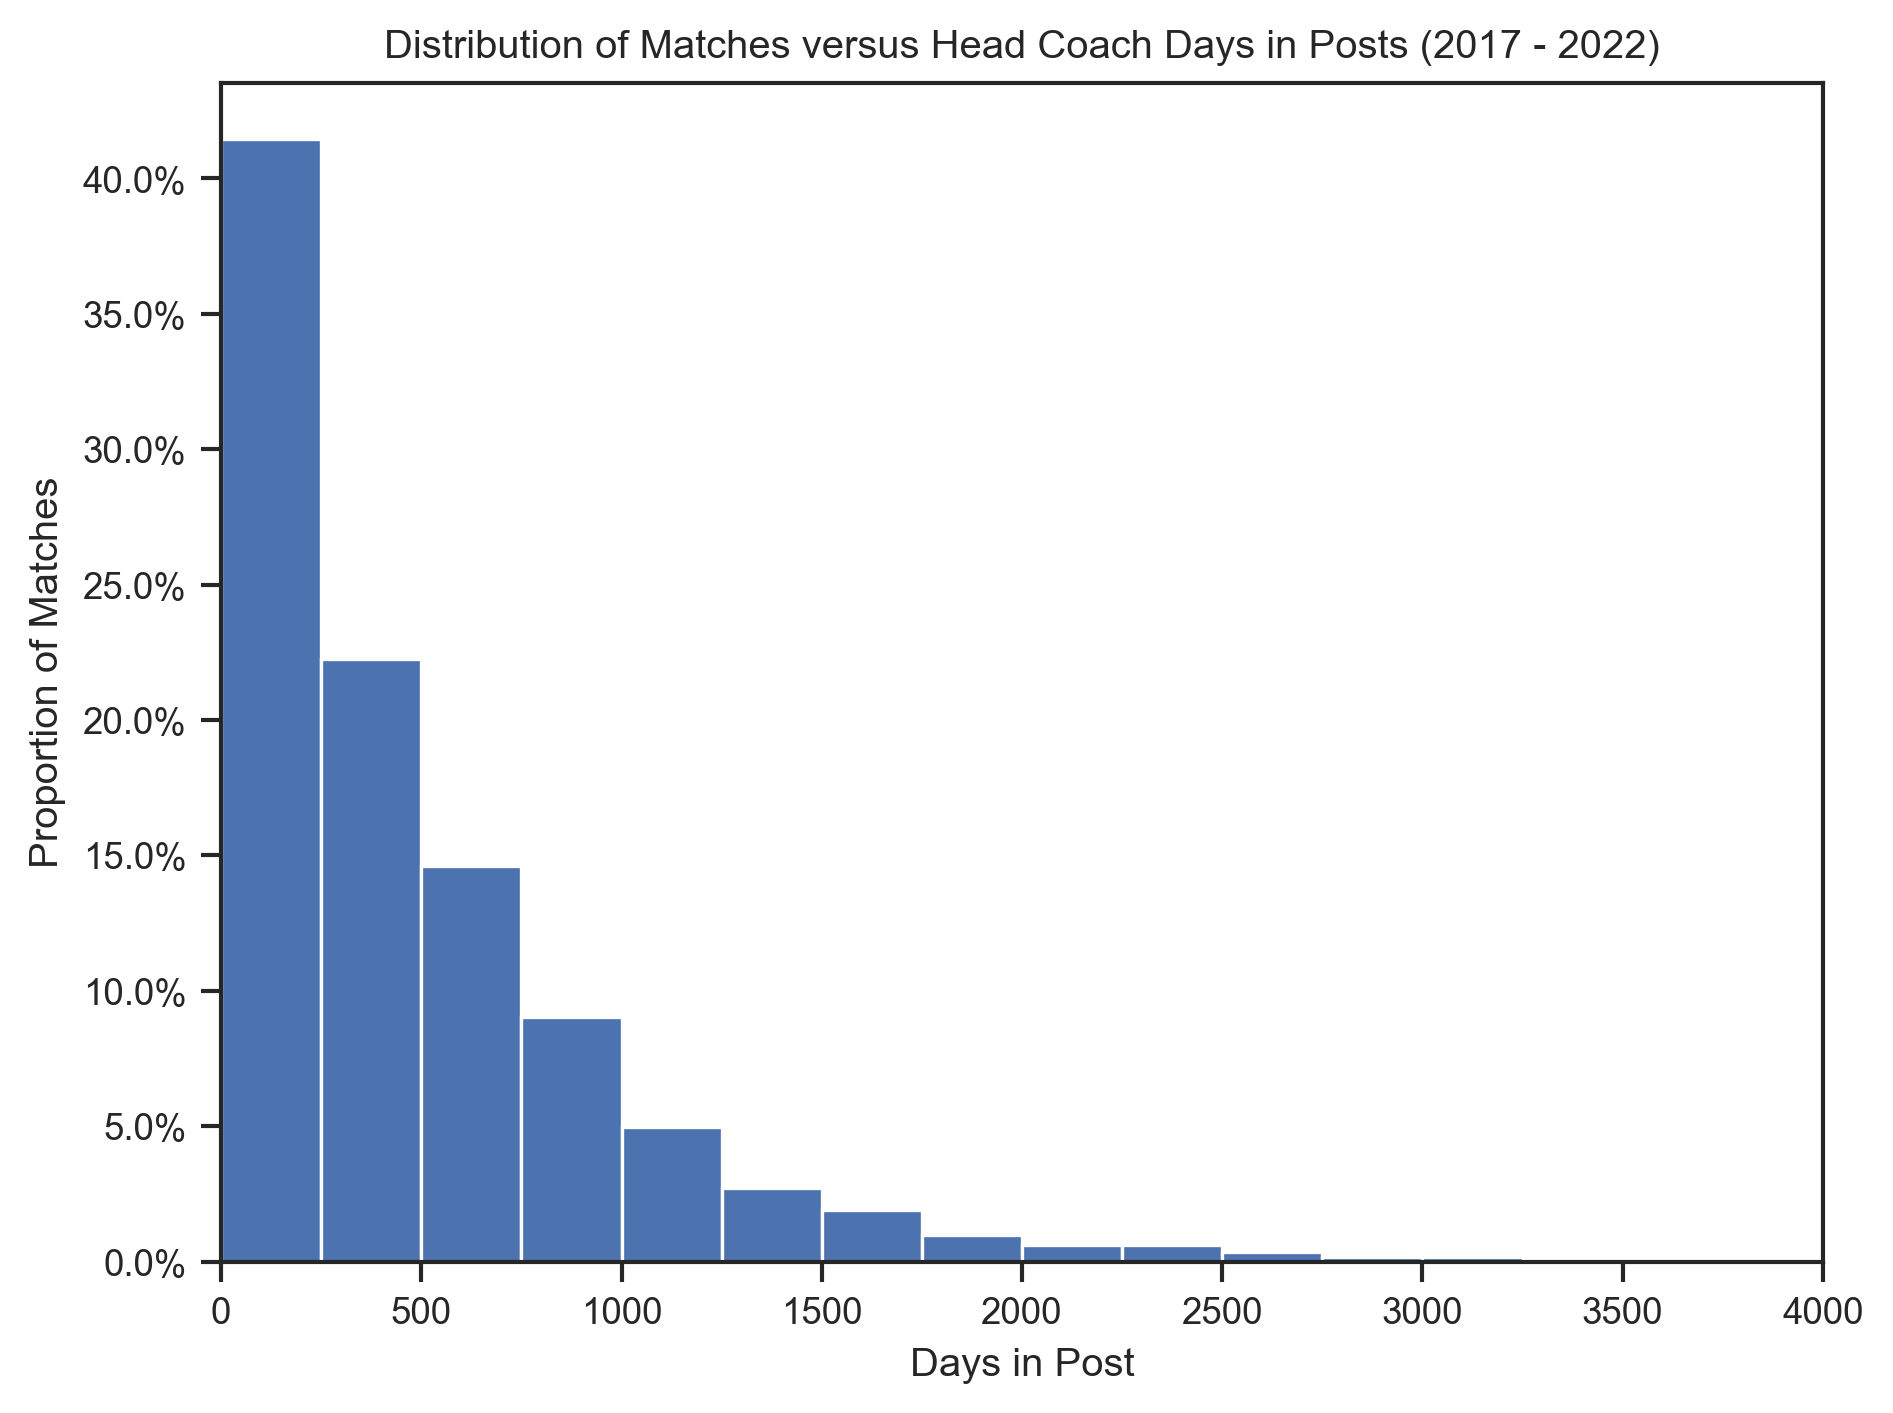

In [776]:
#| label: match_distribution_over_coach_tenure
# Create a histogram of 'match_count' over 'days_in_post'
plt.figure()
sns.histplot(data=match_results, x='DaysInPost', bins=16, stat='proportion', binrange=(0, 4000), alpha = 1)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xlim(0, 4000)
plt.xlabel('Days in Post')
plt.ylabel('Proportion of Matches')
plt.title('Distribution of Matches versus Head Coach Days in Posts (2017 - 2022)')
plt.show()

In [777]:
def plot_match_outcome_over_coach_tenure(data, y_value, y_label, color):
    # Create a jointplot
    g = sns.jointplot(data=data, x='DaysInPost', y=y_value, kind='reg', 
                      scatter_kws={'alpha':0.5, 'color': color}, 
                      line_kws={'color': color}, 
                      ratio = 3, marginal_ticks = False)
    g.figure.set_figwidth(6)
    g.figure.set_figheight(2)
    g.figure.suptitle(f'Match outcome over Head Coach Days in Post', x = 0.4, y = 1.1)
    g.set_axis_labels('Head Coach Days in Post', 'Match Outcome')
    
    # Legend
    r, p = pearsonr(data['DaysInPost'], data[y_value])
    legend = g.ax_joint.legend([f'r = {r:.2f}, p = {p:.2f}'], loc='upper left', bbox_to_anchor=(1, 1.6))
    legend.set_title("Pearson correlation")
    
    # Set y-axis tick
    g.ax_joint.set_yticks([0, 1])
    g.ax_joint.set_yticklabels(['not ' + y_label, y_label])
    # Save the figure
    # g.savefig(f'figures/{y_value}_over_coach_tenure.png')

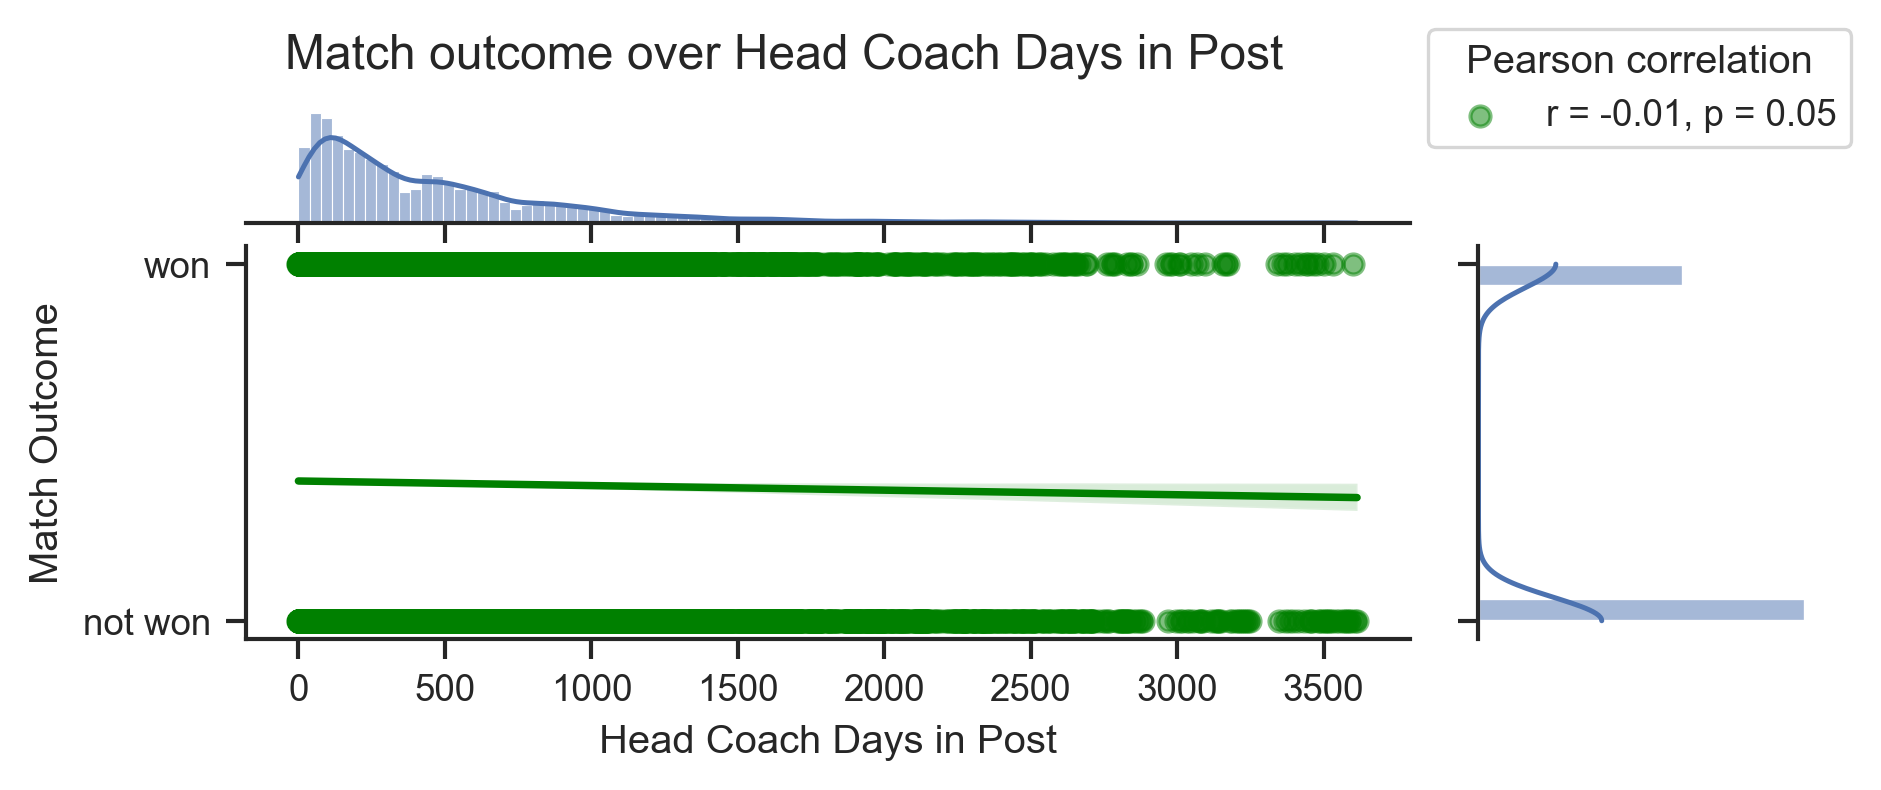

In [778]:
#| label: win_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, 'Win', 'won', 'green')

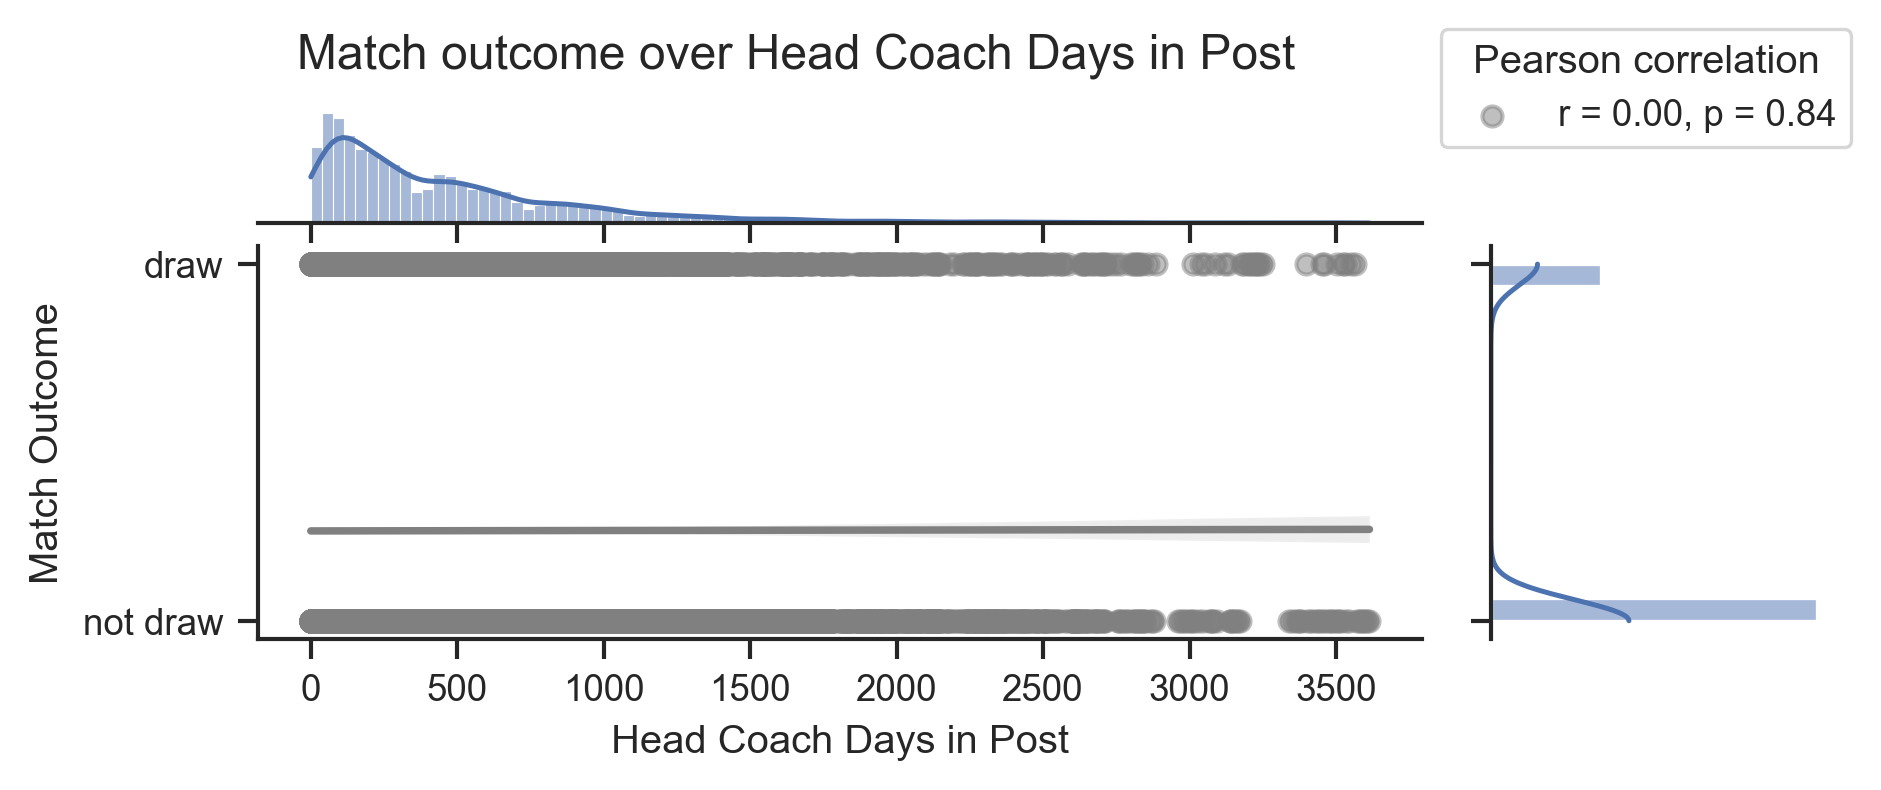

In [779]:
#| label: draw_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, 'Draw', 'draw', 'gray')

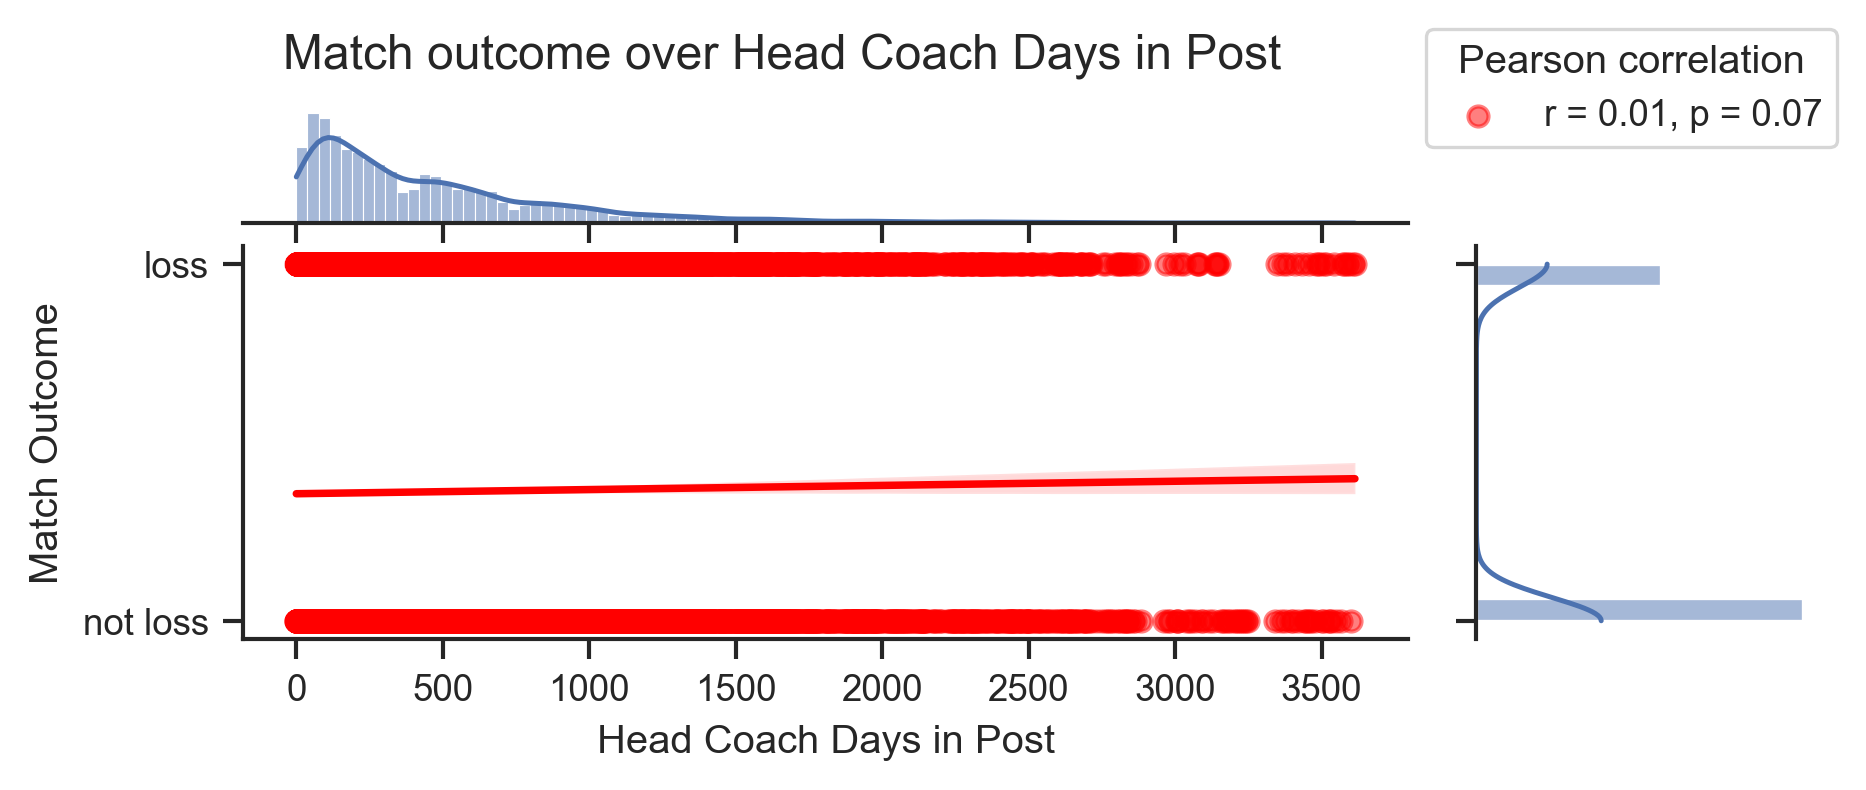

In [780]:
#| label: loss_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, 'Loss', 'loss', 'red')

In [781]:
match_results_bis = match_results[match_results['DaysInPost'] < 1500]
match_results_bis = match_results_bis.groupby('DaysInPost').agg({'Win': 'mean', 'Draw': 'mean', 'Loss': 'mean', 'Result': 'count'})
match_results_bis.columns = ['WinRate', 'DrawRate', 'LossRate', 'MatchCount']
# Add missing days between the first and last day
match_results_bis = match_results_bis.reindex(range(int(min(match_results_bis.index)), int(max(match_results_bis.index) + 1)), fill_value=0)

In [782]:
def weighted_rolling_mean(data, weights, window_size=50):
    def weighted_mean(x):
        return np.average(data.loc[x.index], weights=weights.loc[x.index])

    return data.rolling(window_size, min_periods=1).apply(weighted_mean, raw=False)

window_size = 100

match_results_bis['WinRateRA'] = weighted_rolling_mean(match_results_bis['WinRate'], match_results_bis['MatchCount'], window_size)
match_results_bis['DrawRateRA'] = weighted_rolling_mean(match_results_bis['DrawRate'], match_results_bis['MatchCount'], window_size)
match_results_bis['LossRateRA'] = weighted_rolling_mean(match_results_bis['LossRate'], match_results_bis['MatchCount'], window_size)

# Ensures it sums to 1
(match_results_bis['WinRateRA'] + match_results_bis['DrawRateRA'] + match_results_bis['LossRateRA']).value_counts()

1.0    1461
1.0      39
Name: count, dtype: int64

In [783]:
stats = match_results[match_results['DaysInPost'] < 1500]
n_match = stats['Result'].count()
n_win = stats[stats['Result'] == 'win']['Result'].count()
n_draw = stats[stats['Result'] == 'draw']['Result'].count()
n_loss = stats[stats['Result'] == 'loss']['Result'].count()

Parmi l'ensemble des matchs où l'on possède des informations sur l'entraîneur sportif et où l'entraîneur sportif avait moins de 1500 jours d'ancienneté lors du match :
- le pourcentage de match gagné est de {eval}`n_win/n_match*100:.2f}%`
- le pourcentage de match nul est de {eval}`n_draw/n_match*100:.2f}%` 
- le pourcentage de match perdu est de {eval}`n_loss/n_match*100:.2f}%`.

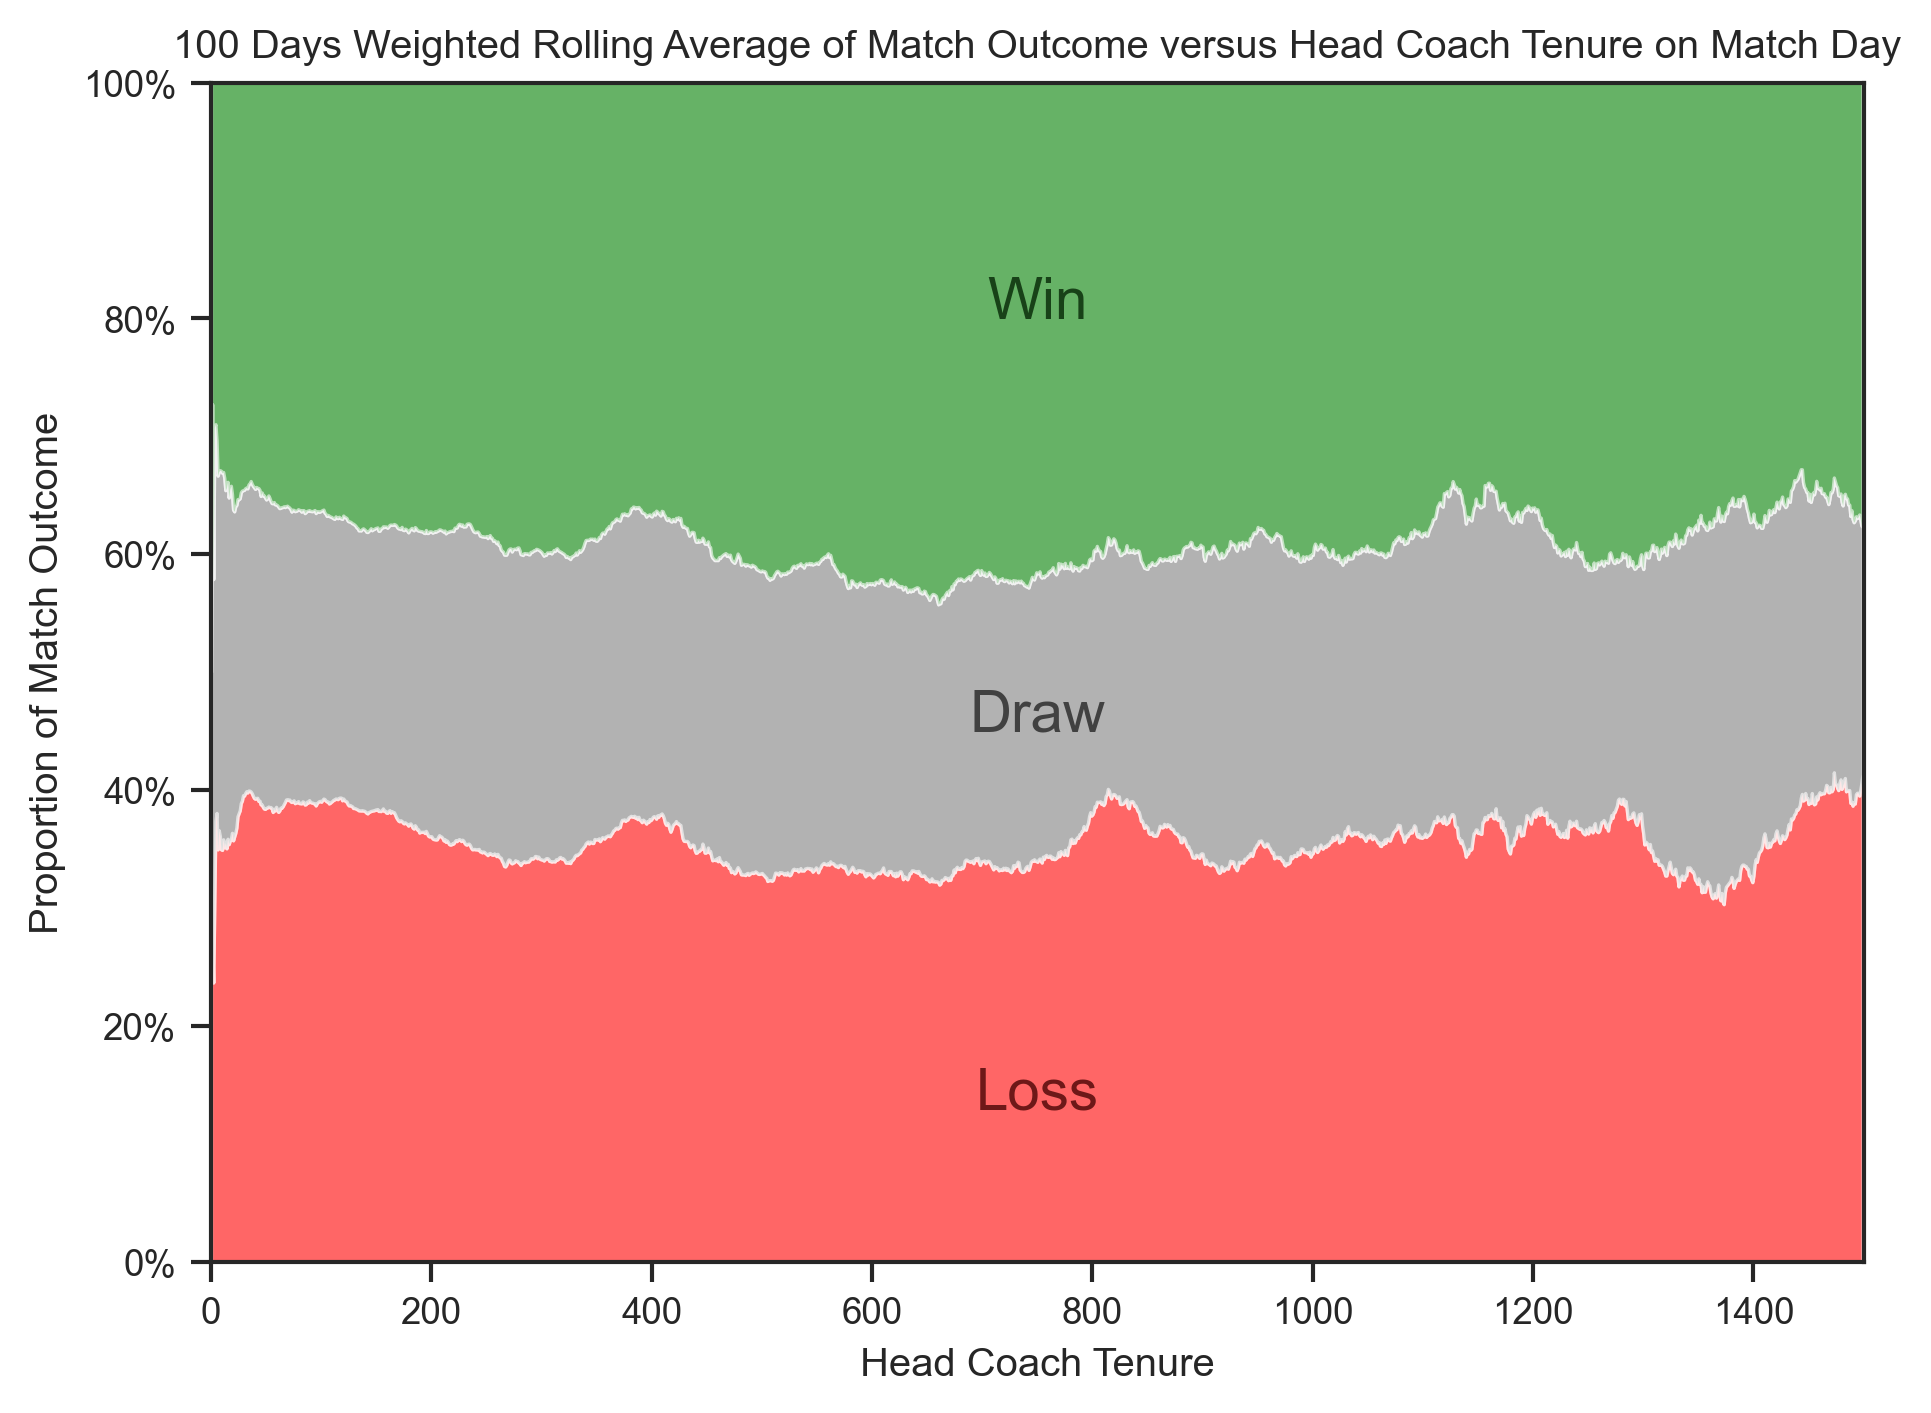

In [784]:
#| label: match_outcome_over_coach_tenure
plt.figure()
plt.stackplot(  match_results_bis.index, match_results_bis['LossRateRA'], match_results_bis['DrawRateRA'],
                match_results_bis['WinRateRA'], colors=['red', 'gray', 'green'], alpha=0.60)
plt.xlabel('Head Coach Tenure')
plt.ylabel('Proportion of Match Outcome')
plt.title(f'{window_size} Days Weighted Rolling Average of Match Outcome versus Head Coach Tenure on Match Day');
plt.gca().spines['left'].set_position(('data', 0))
plt.gca().spines['bottom'].set_position(('data', 0))
plt.gca().spines['top'].set_position(('data', 1))
plt.gca().spines['right'].set_position(('data', 1500))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xlim(0, 1500)
plt.ylim(0, 1)

colors = ['green', 'gray', 'red']
light_colors = [sns.dark_palette(color, as_cmap=True)(0.3) for color in colors]
plt.text(750, 0.8, 'Win', color=light_colors[0], ha='center', fontsize=14)
plt.text(750, 0.45, 'Draw', color=light_colors[1], ha='center', fontsize=14)
plt.text(750, 0.13, 'Loss', color=light_colors[2], ha='center', fontsize=14);